In [1]:
import pandas as pd

from datetime import datetime
from datetime import date

import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re

import unicodedata
import math
from itertools import cycle
import xlsxwriter
import pyodbc
from datetime import timedelta
import matplotlib

import random
from IPython.display import display, HTML

import sys

import tkinter as tk
from tkinter import ttk
from tkinter import PhotoImage
from PIL import ImageTk, Image
import os

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

def calcula_dv(rut_base):
    # CONVERTIR EL RUT BASE A UNA CADENA Y REVERTIRLA
    reversed_digits = list(map(int, str(rut_base)[::-1]))
    # DEFINIR LOS FACTORES (2..7) QUE SE REPITEN EN CICLO
    factors = list(range(2, 8))
    # CALCULAR LA SUMA DE LOS PRODUCTO
    suma = sum(d * f for d, f in zip(reversed_digits, factors * (len(reversed_digits) // len(factors) + 1)))
    # CALCULA DV
    dv = (-suma) % 11
    return 'K' if dv == 10 else str(dv)

def remove_leading_zeros(rut):
    rut_part, dv = rut.split('-')
    rut_part = rut_part.lstrip('0')
    if not rut_part:
        rut_part = '0'
    return f"{rut_part}-{dv}"

def reemplazar_k(identificador):
    return identificador[:-1:] + identificador[-1].upper()

def separar_rut(numero):
    numero_str = str(numero)
    # TOMAR EL ULTIMO DIGITO
    parte_numerica = numero_str[:-1]
    digito_verificador = numero_str[-1]
    # FORMTATEAR GUION
    rut_formateado = f"{parte_numerica}-{digito_verificador}"
    return rut_formateado

pd.options.display.float_format = "{:,.0f}".format

In [2]:
%store -r df_saldo_caja
%store -r df_custodia_detalle
%store -r df_operaciones
%store -r df_DATOS_clientes
%store -r df_APORET_detalle  
%store -r df_muestra2 
%store -r m   

## CRITERIOS APORTES Y RESCATES

### CRITERIOS APORTES 

#### 1. APORTE SUPERA UMBRAL 

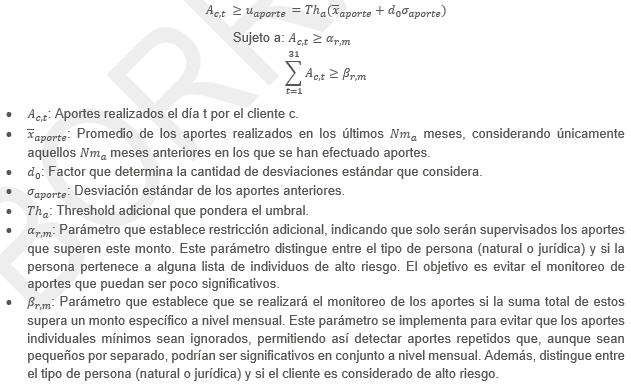

**PARÁMETROS DIFERENCIADOS:**
Según el tipo de persona son los parámetros $\alpha$ y $\beta$, que definen los aportes a monitorear 
al igual que si la persona pertenece a una lista de alto riesgo como:

&emsp;- Personas Expuestas Políticamente <br>
&emsp;- Causa Judicial por Delito Precedente <br>
&emsp;- Persona Jurídica o Natural residente en comuna con Zona Franca <br>
&emsp;- Listado de países y territorios no cooperantes según la OCDE y GAFI <br>
&emsp;- Personas Jurídicas con giro catalogado como riesgoso <br>

<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>Alpha</th>
            <th>Beta</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>500,000</td>
            <td>8,000,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td>BAJO</td>
            <td>1,000,000</td>
            <td>16,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td>ALTO</td>
            <td>3,500,000</td>
            <td>35,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td>BAJO</td>
            <td>5,000,000</td>
            <td>50,000,000</td>
        </tr>
    </tbody>
</table>



In [3]:
# ASIGNAR ALPHA Y BETA
def asignar_limites(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'ALTO':
            return 500_000, 8_000_000  # Alpha_NR, Beta_NR
        else:
            return 1_000_000, 16_000_000  # Alpha_N, Beta_N
    elif row['TIPO_PER'] == 'JURIDICA':
        if row['RIESGO'] == 'ALTO':
            return 3_500_000, 35_000_000  # Alpha_NR, Beta_NR
        else:
            return 5_000_000, 50_000_000  # Alpha_N, Beta_N

**SUB DF DE APORTES A MONITOREAR:**
De todos los aportes disponibles se toma una porción de los aportes dados los parámetros $\alpha$ y $\beta$,
se arma estadística del promedio, desviación estándar de los aportes.

In [4]:
Aportes = df_APORET_detalle[df_APORET_detalle["CARGO_ABONO"] == 'A']
df_Aportes_copia = Aportes.copy()
df_Aportes_copia['FECHA_MOVIMIENTO'] = pd.to_datetime(df_Aportes_copia['FECHA_MOVIMIENTO'])  
df_Aportes_copia['MES'] = df_Aportes_copia['FECHA_MOVIMIENTO'].dt.to_period('M') 

# MERGE CON DF_MUESTRA2 PARA OBTENER 'TIPO_PER' Y 'RIESGO' ASOCIADOS AL 'IDENTIFICADOR'
df_Aportes_copia = df_Aportes_copia.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left')

# CREA COLUMNAS ALPHA Y BETA, filtrar aportes > ALPHA
df_Aportes_copia[['Alpha', 'Beta']] = df_Aportes_copia.apply(asignar_limites, axis=1, result_type='expand')
df_Aportes_copia_filtrado = df_Aportes_copia[df_Aportes_copia['MONTO_CLP'] >= df_Aportes_copia['Alpha']]

# RESUMEN POR CLIENTE Y MES, SUMANDO LOS MONTOS
df_resumen_A = df_Aportes_copia.groupby(['IDENTIFICADOR', 'MES'])['MONTO_CLP'].sum().reset_index()
# IDENTIFICAR LOS MESES DONDE EL TOTAL SUPERA BETA
meses_superan_Beta_A = df_resumen_A.merge(df_Aportes_copia[['IDENTIFICADOR', 'MES', 'Beta']].drop_duplicates(),
                                          on=['IDENTIFICADOR', 'MES'])
meses_superan_Beta_A = meses_superan_Beta_A[meses_superan_Beta_A['MONTO_CLP'] >= meses_superan_Beta_A['Beta']][['IDENTIFICADOR', 'MES']]
df_Aportes_copia_superan_Beta = df_Aportes_copia.merge(meses_superan_Beta_A, on=['IDENTIFICADOR', 'MES'])

# DF COMBINADO, CRITERIO ALFA Y BETA
df_combinado_A = pd.concat([df_Aportes_copia_filtrado, df_Aportes_copia_superan_Beta]).drop_duplicates()
# FILTRADO ADICIONAL APORTES SOBRE monto_test
monto_test = 100_000
df_combinado_A = df_combinado_A[df_combinado_A['MONTO_CLP'] >= monto_test]

# COLUMNA AUXILIAR MES_NUM
df_combinado_A['MES_NUM'] = df_combinado_A['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)
df_combinado_A['MES_NUM'] = df_combinado_A['MES_NUM'] - df_combinado_A['MES_NUM'].min() + 1

<table>
  <thead>
    <tr>
      <th>Nm_A</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
  </tbody>
</table>
le>
  

In [5]:
# PARAMETROS ESTADÍSTICA
Nm_A = 4

# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_combinado_A = df_combinado_A.sort_values(by=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'])
df_combinado_A['MES_NUM2'] = (df_combinado_A.groupby('IDENTIFICADOR')['MES_NUM']
                             .rank(method='dense').astype(int))
# SELECCIONA LOS N MESES ANTERIORES
resultados = []
for identificador, grupo in df_combinado_A.groupby('IDENTIFICADOR'):

    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        
        # FILTRAR LAS FILAS DE N MESES ANTERIORES
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_A)]
        promedio_aportes = ultimos_n_meses['MONTO_CLP'].mean()
        std_aportes = ultimos_n_meses['MONTO_CLP'].std()
        # AGREGA RESUTLADO AL DF
        resultados.append({
            'IDENTIFICADOR': identificador,
            'MES': mes_actual,
            'promedio_aportes': promedio_aportes,
            'std_aportes': std_aportes
        })

# CREAR DF
df_resultados_A = pd.DataFrame(resultados)
df_resultados_A = df_resultados_A.drop_duplicates(subset=['IDENTIFICADOR','MES'])

for identifier in df_resultados_A['IDENTIFICADOR'].unique():
    ## INDICES N/A
    indices = df_resultados_A[df_resultados_A['IDENTIFICADOR'] == identifier].index[:Nm_A]
    df_resultados_A.loc[indices, ['promedio_aportes', 'std_aportes']] = 'n/a'

df_grouped_A = df_resultados_A.copy()
df_grouped_A['promedio_aportes'] = pd.to_numeric(df_grouped_A['promedio_aportes'], errors='coerce')
df_grouped_A['std_aportes'] = pd.to_numeric(df_grouped_A['std_aportes'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\2514187367.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'n/a' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados_A.loc[indices, ['promedio_aportes', 'std_aportes']] = 'n/a'


**APORTE SUPERA EL UMBRAL:** $d_0$ cantidad de desviaciones estándar dentro del umbral

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Nm_A</td>
      <td>4</td>
      <td>Número meses de datos de aportes para el umbral</td>
    </tr>
    <tr>
      <td>$d_0$</td>
      <td>3.5</td>
      <td>Cantidad de std</td>
    </tr>
    <tr>
      <td>$th_a$</td>
      <td>1.5</td>
      <td>Threshold en caso de que la std sea nula para hacer más robusto el umbral</td>
    </tr>
    <tr>
      <td>$th_{nstd}$</td>
      <td>2</td>
      <td>Threshold adicional al umbral, lo hace más conservador en caso de que la std sea baja y así el umbral es más robusto</td>
    </tr>
  </tbody>
</table>

In [6]:
# PARÁMETROS
n_meses = 4
d_0 = 3.5
th_a = 1.5
th_nstd = 2

In [7]:
alertas_aporte = []

for id_cliente in df_grouped_A['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_A[df_grouped_A['IDENTIFICADOR'] == id_cliente]
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES').reset_index(drop=True)
    # ITERAR DESDE n_meses HASTA FINAL DF
    for i in range(n_meses, len(df_cliente)):
        # MES ACTUAL Y DATOS CLIENTES
        mes_actual = df_cliente.iloc[i]['MES']
        promedio_aportes = df_cliente.iloc[i]['promedio_aportes']
        std_aportes = df_cliente.iloc[i]['std_aportes']

        # APORTES MES ACTUAL
        aportes_actuales_filtro = df_combinado_A[
            (df_combinado_A['MES'] == mes_actual) &
            (df_combinado_A['IDENTIFICADOR'] == id_cliente)
        ]

        # ITERA SOBRE APORTES
        for _, aporte_fila in aportes_actuales_filtro.iterrows():
            aporte_actual = aporte_fila['MONTO_CLP']
            fecha_movimiento = aporte_fila['FECHA_MOVIMIENTO']

            # UMBRAL
            if std_aportes == 0:
                umbral = promedio_aportes * th_nstd # THRESHOLD SIN STD
            else:
                umbral = th_a *(promedio_aportes + d_0 * std_aportes)  # NORMAL
            
            # OBTIENE APORTES SOBRE UMBRAL
            if aporte_actual > umbral:
                alertas_aporte.append({
                    'MES': mes_actual,
                    'IDENTIFICADOR': id_cliente,
                    'aporte_actual': aporte_actual,
                    'fecha_aporte': fecha_movimiento,
                    'promedio_aportes': promedio_aportes,
                    'std_aportes': std_aportes,
                    'umbral': umbral
                })

df_alerta_APORTESUPERAUMBRAL = pd.DataFrame(alertas_aporte)

In [8]:
df_alerta_APORTESUPERAUMBRAL = pd.merge(df_alerta_APORTESUPERAUMBRAL, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [9]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_APORTESUPERAUMBRAL['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_APORTESUPERAUMBRAL['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_APORTESUPERAUMBRAL.shape[0]}\n",
      df_alerta_APORTESUPERAUMBRAL.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 23 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 6.42 % 
Cantidad de veces que se levanta la señal: 30
 MES
2023-11    2
2024-01    1
2024-02    3
2024-03    7
2024-04    1
2024-05    1
2024-06    3
2024-07    3
2024-09    9
Freq: M, Name: count, dtype: int64


In [10]:
df_alerta_APORTESUPERAUMBRAL_color = df_alerta_APORTESUPERAUMBRAL.copy()
############### COLOR ##################
unique_ids = df_alerta_APORTESUPERAUMBRAL_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
def color_aporte_vs_umbral(row):
    aporte_vs_umbral = row['aporte_actual'] / row['umbral']
    if aporte_vs_umbral > 2:
        return ['background-color: red'] * len(row)  # Rojo claro
    elif aporte_vs_umbral > 1.7:
        return ['background-color: orange'] * len(row)  # Amarillo claro
    else:
        return [''] * len(row)


df_alerta_APORTESUPERAUMBRAL_color = (
    df_alerta_APORTESUPERAUMBRAL_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
    .apply(color_aporte_vs_umbral, axis=1, subset=['aporte_actual', 'umbral'])
)

df_alerta_APORTESUPERAUMBRAL_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\464082306.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\464082306.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,aporte_actual,fecha_aporte,promedio_aportes,std_aportes,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-09,10577379-K,5000000.000000,2024-09-16 00:00:00,1400000.000000,400000.000000,4200000.000000,Cesar Esteban Bruna Diaz,NATURAL,
1,2024-02,11277742-3,10000000.000000,2024-02-16 00:00:00,3000000.000000,0.000000,6000000.000000,FERNANDO RODOLFO URRA HERRERA,NATURAL,
2,2024-02,11277742-3,20000000.000000,2024-02-16 00:00:00,3000000.000000,0.000000,6000000.000000,FERNANDO RODOLFO URRA HERRERA,NATURAL,
3,2024-07,13256647-K,13402269.573000,2024-07-23 00:00:00,2342857.142857,1604012.825029,11935353.045687,VERONICA REESE VIVANCO,NATURAL,
4,2024-09,13668051-K,4500000.000000,2024-09-10 00:00:00,1285714.285714,487950.036474,4490309.120061,BRAULIO HERNAN MENDOZA LEON,NATURAL,
5,2024-09,13952791-7,50000000.000000,2024-09-12 00:00:00,4542857.142857,919886.121316,11643687.851197,IGNACIO ANTONIO VÉJAR MAYORA,NATURAL,
6,2024-05,14010714-K,18603400.000000,2024-05-07 00:00:00,3286505.896368,1738600.385683,14057410.869387,FELIPE HARTWIG LANGEVIN,NATURAL,
7,2024-03,15317930-1,7000000.000000,2024-03-18 00:00:00,1441746.571429,551811.773689,5059631.669012,JUAN CARLOS TRONCOSO PINO,NATURAL,
8,2024-03,15317930-1,5500000.000000,2024-03-19 00:00:00,1441746.571429,551811.773689,5059631.669012,JUAN CARLOS TRONCOSO PINO,NATURAL,
9,2023-11,15383710-4,167000000.000000,2023-11-14 00:00:00,4222222.222222,506896.877525,8994541.940339,PABLO RAMÍREZ CALVO,NATURAL,


#### 3. CRITERIO APORTES SIMILARES EN MONTOS

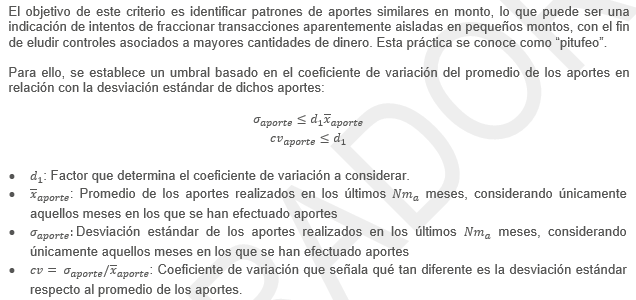

In [11]:
## COEFICIENTE DE VARIACION
df_grouped_A = df_combinado_A.groupby(['MES', 'IDENTIFICADOR']).agg(
    promedio_aportes=('MONTO_CLP', 'mean'),
    std_aportes=('MONTO_CLP', 'std'),
    count_aportes=('MONTO_CLP', 'size')
).reset_index()

d_1 = 0.1
cant_minima_aportes = 5
df_grouped_A['coef_var'] = df_grouped_A['std_aportes'] / df_grouped_A['promedio_aportes']
df_grouped_A['alerta'] = (df_grouped_A['coef_var'] <= d_1) & (df_grouped_A['count_aportes'] >= cant_minima_aportes)

# FILTRA LOS DE LA ALERTA
df_alerta_APORTESIMILARES = df_grouped_A[df_grouped_A['alerta']]
df_alerta_APORTESIMILARES = df_alerta_APORTESIMILARES.reset_index(drop=True)

In [12]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_APORTESIMILARES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_APORTESIMILARES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_APORTESIMILARES.shape[0]}\n",
      df_alerta_APORTESIMILARES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 31 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 8.66 % 
Cantidad de veces que se levanta la señal: 37
 MES
2023-07    1
2023-08    2
2023-10    3
2023-11    4
2023-12    1
2024-01    3
2024-02    1
2024-03    4
2024-04    4
2024-05    4
2024-06    5
2024-07    3
2024-08    2
Freq: M, Name: count, dtype: int64


In [13]:
df_alerta_APORTESIMILARES = pd.merge(df_alerta_APORTESIMILARES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [14]:
############### COLOR ##################
df_alerta_APORTESIMILARES_color = df_alerta_APORTESIMILARES.copy()
unique_ids = df_alerta_APORTESIMILARES_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_APORTESIMILARES_color = (
    df_alerta_APORTESIMILARES_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

#df_alerta_APORTESIMILARES_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\3706790349.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\3706790349.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


#### 4.	APORTES MAYORES AL PATRIMONIO VALORIZADO DEL CLIENTE

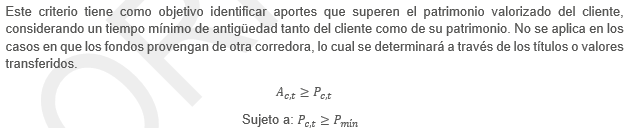

In [15]:
# ASIGNAR ALPHA Y BETA
def asignar_limites_aporte_mayor_custodia(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'PEP':
            return 3_000_000
        else:
            return 7_000_000
    elif row['TIPO_PER'] == 'JURIDICA':
        return 50_000_000

In [16]:
df_custodia_detalle = df_custodia_detalle.copy()
df_custodia_consolidado = df_custodia_detalle.groupby(['IDENTIFICADOR', 'fecha_cierre'], as_index=False).sum('VALOR_MERCADO_CLP')
df_custodia_consolidado = df_custodia_consolidado[['IDENTIFICADOR','fecha_cierre','VALOR_MERCADO_CLP']]

In [17]:
df_diario_A = df_combinado_A.groupby(['IDENTIFICADOR', 'FECHA_MOVIMIENTO']).agg(
    MONTO_CLP=('MONTO_CLP', 'sum')
).reset_index()

In [18]:
df_diario_A.sample()

,IDENTIFICADOR,FECHA_MOVIMIENTO,MONTO_CLP
2601,17317304-0,2024-03-06,"4,000,000"


In [19]:
df_custodia_consolidado_copia = df_custodia_consolidado.merge(
    df_muestra2[['IDENTIFICADOR', 'RIESGO','TIPO_PER','NOMBRE_CLIENTE']], 
    on='IDENTIFICADOR', 
    how='left'  
).fillna(' ')

# CREA COLUMNAS index
df_custodia_consolidado_copia['index_custodia'] = df_custodia_consolidado_copia.apply(asignar_limites_aporte_mayor_custodia, axis=1, result_type='expand')

In [20]:
df_diario_A.sample()

,IDENTIFICADOR,FECHA_MOVIMIENTO,MONTO_CLP
1385,15725884-2,2024-07-25,"42,808,959"


In [21]:
# MERGE df_custodia_consolidado y df_APORET_detalle_2 por IDENTIFICADOR y fechas
df_merged = pd.merge(df_custodia_consolidado_copia, 
                     df_diario_A, 
                     left_on=['IDENTIFICADOR', 'fecha_cierre'], 
                     right_on=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'], 
                     how='inner')

### APORTE (MONTO_CLP) mayor a custodia (VALOR_MERCADO_CLP)
cond1 = df_merged['MONTO_CLP'] > df_merged['VALOR_MERCADO_CLP']
cond2 = df_merged['VALOR_MERCADO_CLP'] > df_merged['index_custodia']

df_aporte_mayor_custodia = (df_merged[cond1 & cond2])


In [22]:
del df_aporte_mayor_custodia['FECHA_MOVIMIENTO']
del df_aporte_mayor_custodia['index_custodia']

In [23]:
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M') 

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\3286359461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')


In [24]:
df_aporte_mayor_custodia

,IDENTIFICADOR,fecha_cierre,VALOR_MERCADO_CLP,RIESGO,TIPO_PER,NOMBRE_CLIENTE,MONTO_CLP,MES
195,11833342-K,2024-08-05,47129306,,NATURAL,MARIANA ORREGO SANCHEZ,"47,555,500",2024-08
196,11862862-4,2024-02-27,178279920,,NATURAL,MARIA DE LOS ANGELES DONOSO ORELLANA,"180,000,000",2024-02
231,12175480-0,2024-09-25,49741050,,NATURAL,PEDRO FELIPE FIGUEROA OPAZO,"50,000,000",2024-09
286,12662240-6,2024-03-14,33162880,,NATURAL,CLAUDIA SERVERA CAMPUSANO,"33,500,000",2024-03
469,13883339-9,2024-01-29,195583973,,NATURAL,JOSÉ ANDRÉS BARRIGA FEHRMAN,"238,751,905",2024-01
529,14010714-K,2024-05-07,8099191,,NATURAL,FELIPE HARTWIG LANGEVIN,"18,603,400",2024-05
557,14021499-K,2024-05-13,27460959,,NATURAL,JUAN CARLOS MUÑOZ REBOLLEDO,"40,000,000",2024-05
584,14376204-1,2024-07-05,61057506,,NATURAL,PABLO ANTONIO DÍAZ FUENZALIDA,"65,000,000",2024-07
668,15152034-0,2024-05-10,15950631,,NATURAL,PAULA MARCELA VILLALOBOS MOLINA,"148,000,000",2024-05
964,15725884-2,2024-01-22,12682639,,NATURAL,CHRISTOPHER MORAGA INOSTROZA,"40,172,519",2024-01


In [25]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_aporte_mayor_custodia['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_aporte_mayor_custodia['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_aporte_mayor_custodia.shape[0]}\n",
      df_aporte_mayor_custodia.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 36 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 10.06 % 
Cantidad de veces que se levanta la señal: 38
 MES
2024-01    7
2024-02    4
2024-03    3
2024-04    5
2024-05    5
2024-06    1
2024-07    6
2024-08    3
2024-09    4
Freq: M, Name: count, dtype: int64


In [26]:
df_aporte_mayor_custodia_color = df_aporte_mayor_custodia.copy()

unique_ids = df_aporte_mayor_custodia_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
def color_aporte_vs_custodia(row):
    aporte_vs_custodia = row['MONTO_CLP'] / row['VALOR_MERCADO_CLP']
    if aporte_vs_custodia > 1.5:
        return ['background-color: red'] * len(row)  # Rojo claro
    elif aporte_vs_custodia > 1.2:
        return ['background-color: orange'] * len(row)  # Rojo claro
    else:
        return [''] * len(row)


df_aporte_mayor_custodia_color = (
    df_aporte_mayor_custodia_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
    .apply(color_aporte_vs_custodia, axis=1, subset=['VALOR_MERCADO_CLP', 'MONTO_CLP'])
)


C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\2881352000.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\2881352000.py:22: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


#### 5.0 CRITERIO APORTES PRIMER DÍA CONSIDERABLEMENTE ALTO

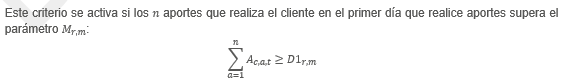

<table>
  <thead>
    <tr>
      <th>TIPO_PER</th>
      <th>RIESGO</th>
      <th>D1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>NATURAL</td>
      <td>ALTO</td>
      <td>10 000 000</td>
    </tr>
    <tr>
      <td>NATURAL</td>
      <td>&nbsp;</td>
      <td>40 000 000</td>
    </tr>
    <tr>
      <td>JURIDICO</td>
      <td>&nbsp;</td>
      <td>250 000 000</td>
    </tr>
  </tbody>
</table>


In [27]:
# M SEGÚN SEGMENTO
def asignar_M(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'PEP':
            return 10_000_000 # Alpha_NR, Beta_NR
        else:
            return 40_000_000  # Alpha_N, Beta_N
    elif row['TIPO_PER'] == 'JURIDICA':
        return 250_000_000  # Alpha_J, Beta_J

In [28]:
df_combinado_A['M'] = df_combinado_A.apply(asignar_M, axis=1)
df_combinado_A_sorted = df_combinado_A.sort_values(by='FECHA_MOVIMIENTO')
Primer_Dia_Aporte_Cliente = df_combinado_A_sorted.groupby('IDENTIFICADOR')['FECHA_MOVIMIENTO'].first().reset_index()

# UNIR CON EL DATAFRAME ORIGINAL PARA OBTENER LOS MOVIMIENTOS CORRESPONDIENTES AL primer dia
Movimientos_Primer_Dia = df_combinado_A_sorted.merge(Primer_Dia_Aporte_Cliente, 
                                                     on=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'], 
                                                     how='inner')

# SUMAR MONTOS PRIMER DIA
Suma_Primer_Aporte_Cliente = Movimientos_Primer_Dia.groupby('IDENTIFICADOR').agg(
    {'MONTO_CLP': 'sum', 'NOMBRE_CLI': 'first', 'FECHA_MOVIMIENTO': 'first', 'M': 'first'}).reset_index()

# FILTRAR
Señal_Primer_Aporte_Grande = Suma_Primer_Aporte_Cliente[Suma_Primer_Aporte_Cliente['MONTO_CLP'] >= Suma_Primer_Aporte_Cliente['M']]
Señal_Primer_Aporte_Grande_Alerta = Señal_Primer_Aporte_Grande[['IDENTIFICADOR', 'NOMBRE_CLI', 'FECHA_MOVIMIENTO', 'MONTO_CLP']].sort_values(by='IDENTIFICADOR')

In [29]:
Señal_Primer_Aporte_Grande_Alerta = pd.merge(Señal_Primer_Aporte_Grande_Alerta, df_muestra2[['IDENTIFICADOR','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [30]:
Señal_Primer_Aporte_Grande_Alerta['MES'] = Señal_Primer_Aporte_Grande_Alerta['FECHA_MOVIMIENTO'].dt.to_period('M') 

In [31]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Primer_Aporte_Grande_Alerta['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Primer_Aporte_Grande_Alerta['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Primer_Aporte_Grande_Alerta.shape[0]}\n",
      Señal_Primer_Aporte_Grande_Alerta.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 31 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 8.66 % 
Cantidad de veces que se levanta la señal: 31
 MES
2023-06    3
2023-07    1
2023-08    2
2024-01    4
2024-02    1
2024-04    2
2024-05    4
2024-06    3
2024-07    5
2024-08    3
2024-09    3
Freq: M, Name: count, dtype: int64


In [32]:
Señal_Primer_Aporte_Grande_Alerta_color = Señal_Primer_Aporte_Grande_Alerta.copy()
############### COLOR ##################
unique_ids = Señal_Primer_Aporte_Grande_Alerta_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)

color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
Señal_Primer_Aporte_Grande_Alerta_color = (
    Señal_Primer_Aporte_Grande_Alerta_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

Señal_Primer_Aporte_Grande_Alerta_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\771155924.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\771155924.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,IDENTIFICADOR,NOMBRE_CLI,FECHA_MOVIMIENTO,MONTO_CLP,TIPO_PER,RIESGO,MES
0,11277742-3,FERNANDO RODOLFO URRA HERRERA,2023-06-16 00:00:00,60000000.000000,NATURAL,,2023-06
1,11833342-K,MARIANA ORREGO SANCHEZ,2024-08-05 00:00:00,47555500.000000,NATURAL,,2024-08
2,11862862-4,MARIA DE LOS ANGELES DONOSO ORELLANA,2024-02-27 00:00:00,180000000.000000,NATURAL,,2024-02
3,12175480-0,PEDRO FELIPE FIGUEROA OPAZO,2024-09-25 00:00:00,50000000.000000,NATURAL,,2024-09
4,13068960-4,WALDO BOWN INTVEEN,2024-05-13 00:00:00,100000000.000000,NATURAL,,2024-05
5,13882906-5,JOSE TOMAS ARRIETA CRUZ,2023-06-28 00:00:00,55000000.000000,NATURAL,,2023-06
6,13883339-9,JOSÉ ANDRÉS BARRIGA FEHRMAN,2024-01-29 00:00:00,238751905.000000,NATURAL,,2024-01
7,14021499-K,JUAN CARLOS MUÑOZ REBOLLEDO,2024-05-13 00:00:00,40000000.000000,NATURAL,,2024-05
8,15152034-0,PAULA MARCELA VILLALOBOS MOLINA,2024-05-10 00:00:00,148000000.000000,NATURAL,,2024-05
9,15960026-2,ANTONIA ANASTASSIOU ROJAS,2023-08-10 00:00:00,55000000.000000,NATURAL,,2023-08


#### 5.1 APORTES DURANTE DÍA ELEVADO (distinto al primer día)

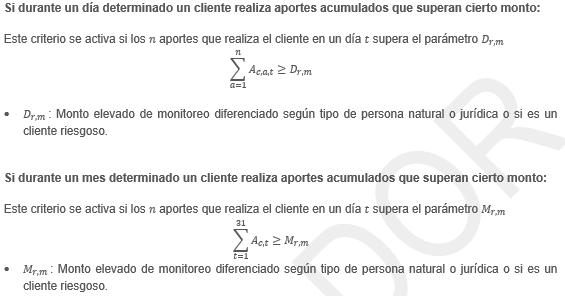

<!-- Tabla D -->
<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>D</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>25,000,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td></td>
            <td>100,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td></td>
            <td>300,000,000</td>
        </tr>
    </tbody>
</table>

<!-- Tabla M -->
<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>M</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>75,000,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td></td>
            <td>200,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td></td>
            <td>500,000,000</td>
        </tr>
    </tbody>
</table>


In [33]:
# AGRUPAR OPERACIONES POR DÍA Y MONTO PARA FILTRAR EL MONTO MÍNIMO DE OPERACIÓN
df_diario_A = df_combinado_A.groupby(['IDENTIFICADOR', 'FECHA_MOVIMIENTO']).agg(
    total_monto_diario=('MONTO_CLP', 'sum')
).reset_index()

df_diario_A['MES'] = df_diario_A['FECHA_MOVIMIENTO'].dt.to_period('M')
# AGRUPAR MENSUALMENTE
df_mensual_A = df_diario_A.groupby(['IDENTIFICADOR', 'MES']).agg(
    total_monto_mensual=('total_monto_diario', 'sum')
).reset_index()

# FUNCIÓN PARA ASIGNAR MONTOS SEGÚN SEGMENTO (DIARIO)
def asignar_adiario(row):
    if row['TIPO_PER'] == 'NATURAL':
        return 25_000_000 if row['RIESGO'] == 'PEP' else 75_000_000
    return 300_000_000 if row['TIPO_PER'] == 'JURIDICA' else None

# FUNCIÓN PARA ASIGNAR MONTOS SEGÚN SEGMENTO (MENSUAL)
def asignar_amensual(row):
    if row['TIPO_PER'] == 'NATURAL':
        return 100_000_000 if row['RIESGO'] == 'PEP' else 200_000_000
    return 500_000_000 if row['TIPO_PER'] == 'JURIDICA' else None

# MERGE DATOS ADICIONALES
df_diario_A = df_diario_A.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO', 'NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna(' ')
df_diario_A['M_diario'] = df_diario_A.apply(asignar_adiario, axis=1)

# PRIMER DÍA
primer_dia = df_diario_A.groupby('IDENTIFICADOR')['FECHA_MOVIMIENTO'].min().reset_index()
primer_dia.columns = ['IDENTIFICADOR', 'primer_dia']

# FILTRAR DISTINTAS PRIMER DÍA
df_diario_A = df_diario_A.merge(primer_dia, on='IDENTIFICADOR', how='left')
df_diario_A_sin_primer_dia = df_diario_A[df_diario_A['FECHA_MOVIMIENTO'] != df_diario_A['primer_dia']]

Señal_Aporte_Diario_Grande = df_diario_A_sin_primer_dia[
    df_diario_A_sin_primer_dia['total_monto_diario'] >= df_diario_A_sin_primer_dia['M_diario']
]


In [34]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Aporte_Diario_Grande['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Aporte_Diario_Grande['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Aporte_Diario_Grande.shape[0]}\n",
      Señal_Aporte_Diario_Grande.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 12 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 3.35 % 
Cantidad de veces que se levanta la señal: 14
 MES
2023-06    1
2023-11    1
2023-12    1
2024-01    1
2024-03    2
2024-06    2
2024-07    1
2024-08    2
2024-09    3
Freq: M, Name: count, dtype: int64


In [35]:
Señal_Aporte_Diario_Grande

,IDENTIFICADOR,FECHA_MOVIMIENTO,total_monto_diario,MES,TIPO_PER,RIESGO,NOMBRE_CLIENTE,M_diario,primer_dia
422,12912156-4,2024-06-10,"110,000,000",2024-06,NATURAL,,LORENA ALCÁNTARA MARTÍNEZ,75000000,2024-01-04
644,13882896-4,2024-07-05,"280,766,585",2024-07,NATURAL,,PAULA MARÍA COSTA ROSS,75000000,2023-06-01
646,13882906-5,2023-06-30,"105,000,000",2023-06,NATURAL,,JOSE TOMAS ARRIETA CRUZ,75000000,2023-06-28
1096,15383710-4,2023-11-14,"167,000,000",2023-11,NATURAL,,PABLO RAMÍREZ CALVO,75000000,2023-06-01
1515,15960026-2,2024-09-12,"90,250,000",2024-09,NATURAL,,ANTONIA ANASTASSIOU ROJAS,75000000,2023-08-10
1786,16369528-6,2024-03-13,"112,500,000",2024-03,NATURAL,,TOMAS VALDES DAVALOS,75000000,2024-03-12
1790,16369528-6,2024-08-29,"150,000,000",2024-08,NATURAL,,TOMAS VALDES DAVALOS,75000000,2024-03-12
2388,16939990-5,2023-12-19,"129,450,000",2023-12,NATURAL,,VICENTE CLARO VALDÉS,75000000,2023-12-13
3238,18586221-6,2024-06-26,"108,462,029",2024-06,NATURAL,,CRISTIÁN VALCK URZÚA,75000000,2024-05-28
4064,5549423-1,2024-03-15,"95,000,000",2024-03,NATURAL,,LEONEL FERNANDO SEARLE COUVE,75000000,2024-03-12


#### 5.2 APORTES DURANTE UN MES ELEVADO

In [36]:
df_mensual_A = df_diario_A.groupby(['IDENTIFICADOR', 'MES']).agg(
    total_monto_mensual=('total_monto_diario', 'sum'),
    dias_aportes=('FECHA_MOVIMIENTO', 'nunique')  # Cuenta días únicos de aportes
).reset_index()



df_mensual_A = df_mensual_A.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER','RIESGO','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna(' ')
df_mensual_A['M_mensual'] = df_mensual_A.apply(asignar_amensual, axis=1)
Señal_Aporte_Mensual_Grande = df_mensual_A[(df_mensual_A['total_monto_mensual'] >= df_mensual_A['M_mensual']) & (df_mensual_A['dias_aportes'] >= 2)]

In [37]:
Señal_Aporte_Mensual_Grande

,IDENTIFICADOR,MES,total_monto_mensual,dias_aportes,TIPO_PER,RIESGO,NOMBRE_CLIENTE,M_mensual


In [38]:
### ESTADISTICA SEÑAL
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {Señal_Aporte_Mensual_Grande['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * Señal_Aporte_Mensual_Grande['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {Señal_Aporte_Mensual_Grande.shape[0]}\n",
      Señal_Aporte_Mensual_Grande.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 0 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.0 % 
Cantidad de veces que se levanta la señal: 0
 Series([], Freq: M, Name: count, dtype: int64)


#### 6. INCREMENTO EN LA FRECUENCIA DE APORTES

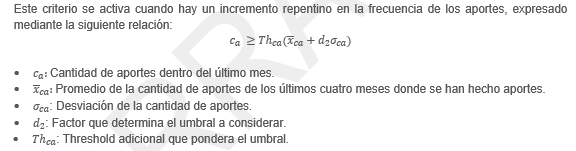

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripcion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>n_meses</td>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
    <tr>
      <td>d_2</td>
      <td>3</td>
      <td>Cantidad de desviación estándar para el umbral</td>
    </tr>
    <tr>
      <td>cant_min_aportes</td>
      <td>5</td>
      <td>Cantidad mínima del aportes para el criterio</td>
    </tr>
    <tr>
      <td>TH</td>
      <td>1,3</td>
      <td>Threshold para robustecer el umbral</td>
    </tr>
  </tbody>
</table>


In [39]:
# PARAMETRO UMBRAL Y CANTIDAD DE MESES A CONSIDERAR
n_meses = 4 
d_2 = 3
cant_min_aportes = 5
TH = 1.3

In [40]:
alertas_frecuencia_A = []
# ITERAR POR CADA IDENTIFICADOR
for id_cliente in df_grouped_A['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_A[df_grouped_A['IDENTIFICADOR'] == id_cliente]
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES')
    
    # COMENZAR DESDE EL n_meses, YA QUE SE REQUIEREN LOS n_meses ANTERIORES
    for i in range(n_meses, len(df_cliente)):
        # SELECCIONAR LOS ÚLTIMOS n_meses DONDE HUBO APORTES
        ultimos_n_meses = df_cliente.iloc[i-n_meses:i]
        
        # FILTRAR APORTES VÁLIDOS
        ultimos_n_meses_validos = ultimos_n_meses[ultimos_n_meses['count_aportes'] > 0]
        
        if len(ultimos_n_meses_validos) < 1:
            continue  # PASA AL SIGUIENTE CLIENTE SI NO HAY DATOS VÁLIDOS
        
        # PROMEDIO Y DESVIACIÓN ESTÁNDAR DE APORTES
        promedio_aportes = ultimos_n_meses_validos['count_aportes'].mean()
        std_aportes = ultimos_n_meses_validos['count_aportes'].std()
        
        # CANTIDAD DE APORTES EN EL MES ACTUAL
        aportes_actual = df_cliente.iloc[i]['count_aportes']
        
        # CONDICIÓN DE UMBRAL FRECUENCIA DE APORTES: c_a ≥ x_ca + d_2 * σ_ca
        if aportes_actual > cant_min_aportes and aportes_actual > TH * (promedio_aportes + d_2 * std_aportes):
            alertas_frecuencia_A.append({
                'MES': df_cliente.iloc[i]['MES'],
                'IDENTIFICADOR': id_cliente,
                'aportes_actual': aportes_actual,
                'promedio_aportes': promedio_aportes,
                'std_aportes': std_aportes,
                'umbral': TH * (promedio_aportes + d_2 * std_aportes)
            })

# Crear DataFrame con las alertas
df_alerta_FRECUENCIAAPORTES = pd.DataFrame(alertas_frecuencia_A)

In [41]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_FRECUENCIAAPORTES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_FRECUENCIAAPORTES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_FRECUENCIAAPORTES.shape[0]}\n",
      df_alerta_FRECUENCIAAPORTES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 17 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 4.75 % 
Cantidad de veces que se levanta la señal: 17
 MES
2023-11    1
2024-01    2
2024-03    3
2024-05    2
2024-06    1
2024-07    2
2024-08    3
2024-09    3
Freq: M, Name: count, dtype: int64


In [42]:
df_alerta_FRECUENCIAAPORTES = pd.merge(df_alerta_FRECUENCIAAPORTES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [43]:
df_alerta_FRECUENCIAAPORTES_color = df_alerta_FRECUENCIAAPORTES.copy()
############### COLOR ##################
unique_ids = df_alerta_FRECUENCIAAPORTES_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_FRECUENCIAAPORTES_color = (
    df_alerta_FRECUENCIAAPORTES_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_alerta_FRECUENCIAAPORTES_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\1274986481.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\1274986481.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,aportes_actual,promedio_aportes,std_aportes,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-03,15669770-2,17,2.000000,0.816497,5.784337,Eduardo Andres Hayden Offermann,NATURAL,
1,2024-06,15837447-1,10,3.750000,0.957427,8.608966,NICOLÁS EDUARDO VALDÉS RIQUELME,NATURAL,
2,2024-01,16017822-1,8,4.000000,0.000000,5.200000,JOSÉ GASPAR DE LA CARRERA GARRIDO,NATURAL,
3,2024-08,16231468-8,8,1.000000,0.000000,1.300000,HERNALDO ANDRÉS GONZÁLEZ MENA,NATURAL,
4,2024-09,16819976-7,6,1.500000,1.000000,5.850000,FERNANDO ESTAY PEREZ,NATURAL,
5,2024-09,17404451-1,10,1.750000,0.500000,4.225000,JUAN ROGERS ALCALDE,NATURAL,
6,2023-11,8833462-0,12,1.250000,0.500000,3.575000,Juan Carlos Zuñiga Diaz,NATURAL,
7,2024-05,17669780-6,10,1.500000,1.000000,5.850000,MARIO PORTILLA ESPINOZA,NATURAL,
8,2024-03,19246134-0,7,1.500000,0.577350,4.201666,CRISTÓBAL GAZALI ALLEN,NATURAL,
9,2024-01,12705757-5,6,1.500000,1.000000,5.850000,MAURICIO KLENNER CATALÁN,NATURAL,


#### 7. CLIENTE APORTA Y TIENE EL DINERO INMOVILIZADO

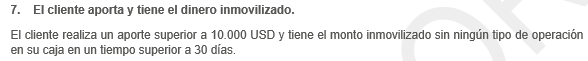

In [44]:
monto_inmovilizado = 10_000_000

In [45]:
df_saldo_caja['FECHA_CIERRE'] = pd.to_datetime(df_saldo_caja['FECHA_CIERRE'])
df_saldo_caja = df_saldo_caja[df_saldo_caja['MONTO_EN_PESOS'] > monto_inmovilizado]
df_saldo_caja = df_saldo_caja.sort_values(['IDENTIFICADOR', 'TIPO_CAJA', 'FECHA_CIERRE'])

def find_same_monto_consecutive_months(group):
    group['year_month_diff'] = (
        (group['FECHA_CIERRE'].dt.year - group['FECHA_CIERRE'].dt.year.shift(1)) * 12 +
        (group['FECHA_CIERRE'].dt.month - group['FECHA_CIERRE'].dt.month.shift(1))
    )
    
    group['same_monto_consecutive'] = (group['year_month_diff'] == 1) & (group['MONTO_MON_CAJA'] == group['MONTO_MON_CAJA'].shift(1))
    

    return group[group['same_monto_consecutive']]

result_df = df_saldo_caja.groupby(['IDENTIFICADOR', 'TIPO_CAJA']).apply(find_same_monto_consecutive_months).reset_index(drop=True)

#### restante ###
df_monto_inmovilizado = result_df.copy()
del df_monto_inmovilizado['ESTADO']
del df_monto_inmovilizado['year_month_diff']
del df_monto_inmovilizado['same_monto_consecutive']
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M')  

In [46]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_monto_inmovilizado['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_monto_inmovilizado['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_monto_inmovilizado.shape[0]}\n",
      df_monto_inmovilizado.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 2 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.56 % 
Cantidad de veces que se levanta la señal: 2
 MES
2024-02    1
2024-10    1
Freq: M, Name: count, dtype: int64


In [47]:
df_operaciones.loc[df_operaciones['COD_MONEDA_OP'] == 'CLP', 'TIPO_CAJA'] = 'CAJA PESOS'
df_operaciones.loc[df_operaciones['COD_MONEDA_OP'] == 'USD', 'TIPO_CAJA'] = 'CAJA DOLAR'

In [48]:
# checkear si no hay operaciones en ese periodo
def check_operations(row, df_operaciones):
    ID1 = row['IDENTIFICADOR']
    NUM_CUENTA1 = row['NUM_CUENTA']
    TIPO_CAJA1 = row['TIPO_CAJA']
    FECHA_CIERRE1 = pd.to_datetime(row['FECHA_CIERRE'])

    # condiciones
    c1 = df_operaciones['IDENTIFICADOR'] == ID1
    c2 = df_operaciones['NUM_CUENTA'] == NUM_CUENTA1
    c3 = df_operaciones['TIPO_CAJA'] == TIPO_CAJA1
    c4 = (df_operaciones['FECHA_OPERACION'] >= (FECHA_CIERRE1 - pd.DateOffset(months=1))) & (df_operaciones['FECHA_OPERACION'] <= FECHA_CIERRE1)

    filtered_df = df_operaciones[c1 & c2 & c3 & c4]
    return filtered_df.empty

df_monto_inmovilizado['is_empty'] = df_monto_inmovilizado.apply(check_operations, axis=1, df_operaciones=df_operaciones)
df_monto_inmovilizado

,NOMBRE_ASESOR,IDENTIFICADOR,NUM_CUENTA,NOMBRE_CLI,FECHA_CIERRE,TIPO_CAJA,MONTO_MON_CAJA,MONTO_EN_PESOS,TRANSITO,MES,is_empty
0,BETTERPLAN ADVISORS SPA .,16369528-6,16369528/50,TOMAS VALDES DAVALOS,2024-10-01,CAJA DOLAR,"21,711",19489653,0,2024-10,True
1,RACIONAL .,26205406-3,26205406/60,RODNEY HERNÁNDEZ,2024-02-01,CAJA PESO,"44,000,000",44000000,0,2024-02,True


In [49]:
df_monto_inmovilizado = pd.merge(df_monto_inmovilizado, df_muestra2[['IDENTIFICADOR','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

In [50]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {result_df['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * result_df['IDENTIFICADOR'].nunique() / m, 2)} %")

La cantidad de clientes son: 358  
Clientes con señal de alerta: 2 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.56 %


### CRITERIO RETIROS

**SUB DF DE RESCATES A MONITOREAR:**
De todos los rescates disponibles se toma una porción de los rescates dados los parámetros $\alpha$ y $\beta$,
se arma estadística del promedio, desviación estándar de los rescates.

In [51]:
Rescates = df_APORET_detalle[df_APORET_detalle["CARGO_ABONO"] == 'C']
df_Rescates_copia = Rescates.copy()
df_Rescates_copia['FECHA_MOVIMIENTO'] = pd.to_datetime(df_Rescates_copia['FECHA_MOVIMIENTO'])  
df_Rescates_copia['MES'] = df_Rescates_copia['FECHA_MOVIMIENTO'].dt.to_period('M') 

# MERGE CON DF_MUESTRA2 PARA OBTENER 'TIPO_PER' Y 'RIESGO' ASOCIADOS AL 'IDENTIFICADOR'
df_Rescates_copia = df_Rescates_copia.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left')

# CREA COLUMNAS ALPHA Y BETA
df_Rescates_copia[['Alpha', 'Beta']] = df_Rescates_copia.apply(asignar_limites, axis=1, result_type='expand')
# FILTRAR APORTES MAYORES A ALPHA
df_Rescates_copia_filtrado = df_Rescates_copia[df_Rescates_copia['MONTO_CLP'] >= df_Rescates_copia['Alpha']]

# RESUMEN POR CLIENTE Y MES, SUMANDO LOS MONTOS
df_resumen_R = df_Rescates_copia.groupby(['IDENTIFICADOR', 'MES'])['MONTO_CLP'].sum().reset_index()
# IDENTIFICAR LOS MESES DONDE EL TOTAL SUPERA BETA
meses_superan_Beta_R = df_resumen_R.merge(df_Rescates_copia[['IDENTIFICADOR', 'MES', 'Beta']].drop_duplicates(),
                                          on=['IDENTIFICADOR', 'MES'])
meses_superan_Beta_R = meses_superan_Beta_R[meses_superan_Beta_R['MONTO_CLP'] >= meses_superan_Beta_R['Beta']][['IDENTIFICADOR', 'MES']]
df_Rescates_copia_superan_Beta = df_Rescates_copia.merge(meses_superan_Beta_R, on=['IDENTIFICADOR', 'MES'])

# DF COMBINADO
df_combinado_R = pd.concat([df_Rescates_copia_filtrado, df_Rescates_copia_superan_Beta]).drop_duplicates()
df_combinado_R['MES_NUM'] = df_combinado_R['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)

<table>
  <thead>
    <tr>
      <th>Nm_R</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de rescates</td>
    </tr>
  </tbody>
</table>


In [52]:
# PARAMETROS ESTADÍSTICA
Nm_R = 4

# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_combinado_R = df_combinado_R.sort_values(by=['IDENTIFICADOR', 'FECHA_MOVIMIENTO'])
df_combinado_R['MES_NUM2'] = (df_combinado_R.groupby('IDENTIFICADOR')['MES_NUM']
                             .rank(method='dense').astype(int))
# SELECCIONA LOS N MESES ANTERIORES
resultados = []
for identificador, grupo in df_combinado_R.groupby('IDENTIFICADOR'):
    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        # FILTRAR LAS FILAS DE N MESES ANTERIORES
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_R)]
        
        promedio_rescates = ultimos_n_meses['MONTO_CLP'].mean()
        std_rescates = ultimos_n_meses['MONTO_CLP'].std()
        
        # AGREGA RESUTLADO AL DF
        resultados.append({
            'IDENTIFICADOR': identificador,
            'MES': mes_actual,
            'promedio_rescates': promedio_rescates,
            'std_rescates': std_rescates
        })

df_resultados_R = pd.DataFrame(resultados)
df_resultados_R = df_resultados_R.drop_duplicates(subset=['IDENTIFICADOR','MES'])

for identifier in df_resultados_R['IDENTIFICADOR'].unique():
    ## INDICES N/A
    indices = df_resultados_R[df_resultados_R['IDENTIFICADOR'] == identifier].index[:Nm_R]
    df_resultados_R.loc[indices, ['promedio_rescates', 'std_rescates']] = 'n/a'

df_grouped_R = df_resultados_R.copy()
df_grouped_R['promedio_rescates'] = pd.to_numeric(df_grouped_R['promedio_rescates'], errors='coerce')
df_grouped_R['std_rescates'] = pd.to_numeric(df_grouped_R['std_rescates'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\2217275593.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'n/a' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados_R.loc[indices, ['promedio_rescates', 'std_rescates']] = 'n/a'


#### 1. CRITERIO RETIROS SIMILARES EN MONTOS

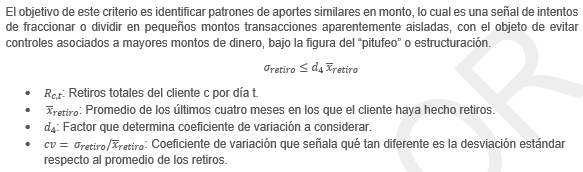

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>cant_minima_retiros</td>
      <td>5</td>
      <td>Cantidad mínima de retiros para evitar aplicar el criterio en rescates insuficientes</td>
    </tr>
    <tr>
      <td>$d_{3}$</td>
      <td>0.1</td>
      <td>Coeficiente de variación que relaciona que tan distinto es el promedio respecto a la desviación estándar para identificar rescates similares</td>
    </tr>
  </tbody>
</table>


In [53]:
cant_minima_retiros = 5
d_3 = 0.1

## COEFICIENTE DE VARIACION
df_grouped_R = df_combinado_R.groupby(['MES', 'IDENTIFICADOR']).agg(
    promedio_rescates=('MONTO_CLP', 'mean'),
    std_rescates=('MONTO_CLP', 'std'),
    count_rescates=('MONTO_CLP', 'size')
).reset_index()

df_grouped_R['coef_var'] = df_grouped_R['std_rescates'] / df_grouped_R['promedio_rescates']
df_grouped_R['alerta'] = (df_grouped_R['coef_var'] <= d_3) & (df_grouped_R['count_rescates'] >= cant_minima_retiros)

# FILTRA LOS DE LA ALERTA
df_alerta_RETIROSSIMILARES = df_grouped_R[df_grouped_R['alerta']]
df_alerta_RETIROSSIMILARES = df_alerta_RETIROSSIMILARES.reset_index(drop=True)

In [54]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_RETIROSSIMILARES['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_RETIROSSIMILARES['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_RETIROSSIMILARES.shape[0]}\n",
      df_alerta_RETIROSSIMILARES.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 4 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 1.12 % 
Cantidad de veces que se levanta la señal: 5
 MES
2023-07    1
2024-03    1
2024-05    2
2024-06    1
Freq: M, Name: count, dtype: int64


In [55]:
df_alerta_RETIROSSIMILARES = pd.merge(df_alerta_RETIROSSIMILARES, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

In [56]:
df_alerta_RETIROSSIMILARES_color = df_alerta_RETIROSSIMILARES.copy()
############### COLOR ##################
unique_ids = df_alerta_RETIROSSIMILARES_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_RETIROSSIMILARES_color = (
    df_alerta_RETIROSSIMILARES_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_alerta_RETIROSSIMILARES_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\283069810.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\283069810.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,promedio_rescates,std_rescates,count_rescates,coef_var,alerta,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2023-07,14122628-2,4933119.194980,51759.976987,5,0.010492,True,MATIAS RICARDO SILVA GONZALEZ,NATURAL,
1,2024-03,16370075-1,6553182.370200,635997.732826,6,0.097052,True,Andrés Adolfo Ovalle Andrews,NATURAL,
2,2024-05,16666615-5,4849212.037400,297933.987037,11,0.061440,True,HERNAN GUILLERMO MOLLER ZAVALLA,NATURAL,
3,2024-05,17669780-6,4952139.205100,8855.471416,7,0.001788,True,MARIO PORTILLA ESPINOZA,NATURAL,
4,2024-06,17669780-6,4764102.892537,369431.965302,8,0.077545,True,MARIO PORTILLA ESPINOZA,NATURAL,


#### 2. INCREMENTO EN LA FRECUENCIA DE RETIROS

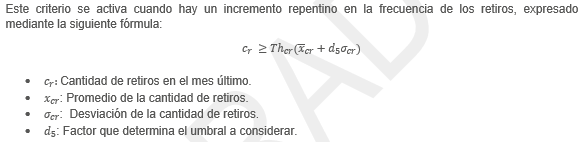

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripcion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>n_meses</td>
      <td>4</td>
      <td>Cantidad de meses para estadísticas de promedio y std de aportes</td>
    </tr>
    <tr>
      <td>$d_{4}$</td>
      <td>3</td>
      <td>Cantidad de desviación estándar para el umbral</td>
    </tr>
    <tr>
      <td>cant_min_rescates</td>
      <td>5</td>
      <td>Cantidad mínima de rescates para el criterio</td>
    </tr>
    <tr>
      <td>$TH_{R}$</td>
      <td>1,3</td>
      <td>Threshold para robustecer el umbral</td>
    </tr>
  </tbody>
</table>


In [57]:
# PARAMETRO UMBRAL Y CANTIDAD DE MESES A CONSIDERAR
n_meses = 4 
d_4 = 3
cant_min_rescates = 5
TH_R = 1.5

In [58]:
alertas_frecuencia_R = []
# ITERAR POR CADA IDENTIFICADOR
for id_cliente in df_grouped_R['IDENTIFICADOR'].unique():
    df_cliente = df_grouped_R[df_grouped_R['IDENTIFICADOR'] == id_cliente]
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES')
    
    # COMENZAR DESDE EL MES n_meses
    for i in range(n_meses, len(df_cliente)):
        # SELECCIONAR LOS ÚLTIMOS n_meses
        ultimos_n_meses = df_cliente.iloc[i-n_meses:i]
        
        # FILTRAR RESCATES VÁLIDOS
        ultimos_n_meses_validos = ultimos_n_meses[ultimos_n_meses['count_rescates'] > 0]
        
        if len(ultimos_n_meses_validos) < 1:
            continue  # PASAR AL SIGUIENTE CLIENTE SI NO HAY DATOS VÁLIDOS
        
        # CALCULAR PROMEDIO Y DESVIACIÓN ESTÁNDAR DE RESCATES
        promedio_rescate = ultimos_n_meses_validos['count_rescates'].mean()
        std_rescate = ultimos_n_meses_validos['count_rescates'].std()
        
        # OBTENER CANTIDAD DE RESCATES DEL MES ACTUAL
        rescates_actual = df_cliente.iloc[i]['count_rescates']
        
        # ESTABLECER CONDICIÓN c_a ≥ x_ca + d_4 * σ_ca
        if rescates_actual > cant_min_rescates and rescates_actual > TH_R * (promedio_rescate + d_4 * std_rescate):
            alertas_frecuencia_R.append({
                'MES': df_cliente.iloc[i]['MES'],
                'IDENTIFICADOR': id_cliente,
                'rescates_actual': rescates_actual,
                'promedio_rescate': promedio_rescate,
                'std_rescate': std_rescate,
                'umbral': promedio_rescate + d_4 * std_rescate
            })

# CREAR DATAFRAME CON LAS ALERTAS
df_alerta_FRECUENCIARETIROS = pd.DataFrame(alertas_frecuencia_R)

In [59]:
df_alerta_FRECUENCIARETIROS = pd.merge(df_alerta_FRECUENCIARETIROS, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna('')

In [60]:
df_alerta_FRECUENCIARETIROS

,MES,IDENTIFICADOR,rescates_actual,promedio_rescate,std_rescate,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-05,17669780-6,7,2,1,4,MARIO PORTILLA ESPINOZA,NATURAL,
1,2024-03,15641707-6,9,2,1,3,MATIAS EDUARDO GOLDSMITH DUENAS,NATURAL,
2,2024-07,15317930-1,9,2,1,5,JUAN CARLOS TRONCOSO PINO,NATURAL,


In [61]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_FRECUENCIARETIROS.shape[0]}\n",
      df_alerta_FRECUENCIARETIROS.value_counts('MES').sort_index())

La cantidad de clientes son: 358  
Clientes con señal de alerta: 3 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 0.84 % 
Cantidad de veces que se levanta la señal: 3
 MES
2024-03    1
2024-05    1
2024-07    1
Freq: M, Name: count, dtype: int64


In [62]:
df_alerta_FRECUENCIARETIROS_color = df_alerta_FRECUENCIARETIROS.copy()
############### COLOR ##################
unique_ids = df_alerta_FRECUENCIARETIROS['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_alerta_FRECUENCIARETIROS_color = (
    df_alerta_FRECUENCIARETIROS_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_alerta_FRECUENCIARETIROS_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\1875345218.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\1875345218.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,IDENTIFICADOR,rescates_actual,promedio_rescate,std_rescate,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-05,17669780-6,7,1.500000,1.000000,4.500000,MARIO PORTILLA ESPINOZA,NATURAL,
1,2024-03,15641707-6,9,1.500000,0.577350,3.232051,MATIAS EDUARDO GOLDSMITH DUENAS,NATURAL,
2,2024-07,15317930-1,9,1.750000,0.957427,4.622281,JUAN CARLOS TRONCOSO PINO,NATURAL,


In [111]:
df_combinado_A[df_combinado_A['IDENTIFICADOR'] == '18378546-K']

,CARGO_ABONO,NUM_CUENTA,IDENTIFICADOR,NOMBRE_CLI,COD_MOV,DSC_MOV_CAJA,FECHA_MOVIMIENTO,FECHA_LIQUIDACION,MONTO,NOMBRE_ASESOR,TIPO_CAJA,COD_MONEDA,OBS_MOV_CAJA,T_C,MONTO_CLP,MES,TIPO_PER,RIESGO,Alpha,Beta,MES_NUM,MES_NUM2,M
4543,A,18378546/50,18378546-K,ANTONIA FERNANDA NÚÑEZ VILLALOBOS,APO_PAT,APORTE PATRIMONIAL,2024-06-06,2024-06-06,"400,000,000",BETTERPLAN ADVISORS SPA .,CAJA PESO,CLP,[WS],1,"400,000,000",2024-06,NATURAL,NaN,"1,000,000","16,000,000",13,1,40000000


## CRITERIO OPERACIONES

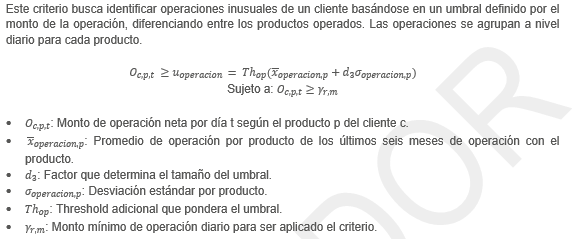

<!-- Tabla O -->
<table>
    <thead>
        <tr>
            <th>TIPO_PER</th>
            <th>RIESGO</th>
            <th>O</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>NATURAL</td>
            <td>ALTO</td>
            <td>500,000</td>
        </tr>
        <tr>
            <td>NATURAL</td>
            <td></td>
            <td>1,000,000</td>
        </tr>
        <tr>
            <td>JURIDICA</td>
            <td></td>
            <td>5,000,000</td>
        </tr>
    </tbody>
</table>


In [63]:
def asignar_O(row):
    if row['TIPO_PER'] == 'NATURAL':
        if row['RIESGO'] == 'PEP':
            return 500_000
        else:
            return 1_000_000
    if row['TIPO_PER'] == 'JURÍDICA':
        return 5_000_000


df_operaciones['COD_TIPO_OPERACION'].value_counts()

cod_tipo_op = ['FWDV'
'FWDC',
'COMPRA_OTC',
'VENTA',   
'VIFM',
'CIRVS',
'VIRVS',
'CIFM',
'COMPRA',
'VIRV',
'CIRV']     

In [64]:
df_operaciones = df_operaciones.copy()
df_operaciones = df_operaciones[df_operaciones['COD_TIPO_OPERACION'].isin(cod_tipo_op)]
# AGRUPAR OPERACIONES POR DIA Y MONTO PARA FILTRAR EL MONTO MINIMO DE OPERACION
df_diario = df_operaciones.groupby(['IDENTIFICADOR', 'FECHA_OPERACION', 'COD_SUB_CLASE_INSTRUMENTO']).agg(
    total_monto_diario=('MONTO_CLP', 'sum')
).reset_index()

In [65]:
df_diario = df_diario.merge(df_muestra2[['IDENTIFICADOR', 'TIPO_PER', 'RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')
df_diario['monto_min_monitoreo'] = df_diario.apply(asignar_O, axis=1, result_type='expand')

# FILTRADO
df_filtrado = df_diario[df_diario['total_monto_diario'] >= df_diario['monto_min_monitoreo']].copy()
df_filtrado['FECHA_OPERACION'] = pd.to_datetime(df_filtrado['FECHA_OPERACION'])  
df_filtrado['MES'] = df_filtrado['FECHA_OPERACION'].dt.to_period('M') 

df_filtrado['MES_NUM'] = df_filtrado['MES'].apply(lambda x: (x.year - 2023) * 12 + x.month)
df_filtrado['MES_NUM'] = df_filtrado['MES_NUM'] - df_filtrado['MES_NUM'].min() + 1

# MAPEO DE MES_NUM A MES_NUM2 PARA HACER NUMERACION CRONOLOGICA POR APARICION
df_filtrado = df_filtrado.sort_values(by=['IDENTIFICADOR', 'FECHA_OPERACION'])
df_filtrado['MES_NUM2'] = df_filtrado.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO', 'MES']).ngroup() + 1

**PARAMETROS ESTADÍSTICA Y UMBRAL**

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Valor</th>
      <th>Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Nm_O</td>
      <td>4</td>
      <td>Número meses de datos de aportes para el umbral</td>
    </tr>
    <tr>
      <td>$d_5$</td>
      <td>3.5</td>
      <td>Cantidad de std</td>
    </tr>
    <tr>
      <td>$th_o$</td>
      <td>1.5</td>
      <td>Threshold en caso de que la std sea nula para hacer más robusto el umbral</td>
    </tr>
    <tr>
      <td>$th_{nstd}$</td>
      <td>1.5</td>
      <td>Threshold adicional al umbral, lo hace más conservador en caso de que la std sea baja y así el umbral es más robusto</td>
    </tr>
  </tbody>
</table>

In [66]:
# PARÁMETRO PARA EL UMBRAL Y NÚMERO DE MESES
d_5 = 3.5
Nm_O = 4
th_o_N = 1.5
th_o_J = 2

In [67]:
resultados = []
# AGRUPAR por IDENTIFICADOR, COD_SUB_CLASE_INSTRUMENTO
for (identificador, cod_instrumento), grupo in df_filtrado.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    
    for idx, row in grupo.iterrows():
        mes_actual = row['MES']
        
        # FILTRAR ULTIMOS Nm_O
        ultimos_n_meses = grupo[(grupo['MES_NUM2'] < row['MES_NUM2']) & 
                                (grupo['MES_NUM2'] >= row['MES_NUM2'] - Nm_O)]
        
        # ESTADÍSTICA
        promedio_operacion = ultimos_n_meses['total_monto_diario'].mean()
        std_operacion = ultimos_n_meses['total_monto_diario'].std()
        
        resultados.append({
            'IDENTIFICADOR': identificador,
            'COD_SUB_CLASE_INSTRUMENTO': cod_instrumento,
            'MES': mes_actual,
            'promedio_operacion': promedio_operacion,
            'std_operacion': std_operacion
        })


df_resultados_O = pd.DataFrame(resultados)
df_resultados_O = df_resultados_O.drop_duplicates(subset=['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO', 'MES'])

# PRIMEROS N MESES, 'promedio_operacion'  'std_operacion' a 'NaN' para cada IDENTIFICADOR y COD_SUB_CLASE_INSTRUMENTO
for (identificador, cod_instrumento), grupo in df_resultados_O.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    indices = grupo.index[:Nm_O]
    df_resultados_O.loc[indices, ['promedio_operacion', 'std_operacion']] = 'NaN'

# CONVERTIR A NUMÉRICO PARA ERRORES
df_grouped_O = df_resultados_O.copy()
df_grouped_O['promedio_operacion'] = pd.to_numeric(df_grouped_O['promedio_operacion'], errors='coerce')
df_grouped_O['std_operacion'] = pd.to_numeric(df_grouped_O['std_operacion'], errors='coerce')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\143341883.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_resultados_O.loc[indices, ['promedio_operacion', 'std_operacion']] = 'NaN'


**OBTENCIÓN UMBRAL**

In [68]:
df_grouped_O = pd.merge(df_grouped_O, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [69]:
alertas_operacion = []

# Agrupar por 'IDENTIFICADOR' y 'COD_SUB_CLASE_INSTRUMENTO'
for (id_cliente, cod_sub_clase), df_cliente in df_grouped_O.groupby(['IDENTIFICADOR', 'COD_SUB_CLASE_INSTRUMENTO']):
    
    # ORDENAR POR MES
    df_cliente = df_cliente.sort_values(by='MES').reset_index(drop=True)

    # ITERAR DESDE Nm_O HASTA FINAL DF
    for i in range(Nm_O, len(df_cliente)):
        # MES ACTUAL Y DATOS CLIENTES
        mes_actual = df_cliente.iloc[i]['MES']
        promedio_operacion = df_cliente.iloc[i]['promedio_operacion']   
        std_operacion = df_cliente.iloc[i]['std_operacion']
        tipo_per = df_cliente.iloc[i]['TIPO_PER']  # Obtener 'TIPO_PER'
        
        # APORTES MES ACTUAL
        operaciones_actuales_filtro = df_filtrado[
            (df_filtrado['MES'] == mes_actual) & 
            (df_filtrado['IDENTIFICADOR'] == id_cliente) & 
            (df_filtrado['COD_SUB_CLASE_INSTRUMENTO'] == cod_sub_clase)
        ]

        # ITERA SOBRE APORTES
        for _, operacion_fila in operaciones_actuales_filtro.iterrows():
            
            operacion_actual = operacion_fila['total_monto_diario']
            fecha_operacion = operacion_fila['FECHA_OPERACION']  # Obtener 'FECHA_OPERACION'
            
            # UMBRAL
            if std_operacion == 0:
                umbral = promedio_operacion * th_nstd  # THRESHOLD SIN STD
            else:
                if tipo_per == 'NATURAL':
                    umbral = th_o_N * (promedio_operacion + d_5 * std_operacion)  # NATURAL
                elif tipo_per == 'JURÍDICA':
                    umbral = th_o_J * (promedio_operacion + d_5 * std_operacion)  # JURIDICA
            
            # OBTIENE APORTES SOBRE UMBRAL
            if operacion_actual > umbral:
                alertas_operacion.append({
                    'MES': mes_actual,
                    'FECHA_OPERACION': fecha_operacion, 
                    'IDENTIFICADOR': id_cliente,
                    'COD_SUB_CLASE_INSTRUMENTO': cod_sub_clase,
                    'operacion_actual': operacion_actual,
                    'promedio_operacion': promedio_operacion,
                    'std_operacion': std_operacion,
                    'umbral': umbral
                })

# Crear DataFrame de alertas
df_alerta_OPERACIONSUPERAUMBRAL = pd.DataFrame(alertas_operacion)


In [70]:
df_alerta_OPERACIONSUPERAUMBRAL = df_alerta_OPERACIONSUPERAUMBRAL.rename(columns={"COD_SUB_CLASE_INSTRUMENTO": "producto"})

In [71]:
df_alerta_OPERACIONSUPERAUMBRAL = pd.merge(df_alerta_OPERACIONSUPERAUMBRAL, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ') #debug

In [72]:
print(f"La cantidad de clientes son: {df_muestra2['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes con señal de alerta: {df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].nunique()} \n" +
      f"Porcentaje de clientes durante el periodo que gatillan la señal de alerta: {round(100 * df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].nunique() / m, 2)} % \n" +
      f"Cantidad de veces que se levanta la señal: {df_alerta_OPERACIONSUPERAUMBRAL.shape[0]}\n",
      df_alerta_OPERACIONSUPERAUMBRAL.value_counts('MES').sort_index()
     )

La cantidad de clientes son: 358  
Clientes con señal de alerta: 47 
Porcentaje de clientes durante el periodo que gatillan la señal de alerta: 13.13 % 
Cantidad de veces que se levanta la señal: 75
 MES
2023-10     2
2023-11     2
2023-12     1
2024-01     2
2024-02     3
2024-03     5
2024-04    11
2024-05     6
2024-06     8
2024-07    16
2024-08     7
2024-09    12
Freq: M, Name: count, dtype: int64


In [73]:
df_alerta_OPERACIONSUPERAUMBRAL_color = df_alerta_OPERACIONSUPERAUMBRAL.copy()
################# COLOR
unique_ids = df_alerta_OPERACIONSUPERAUMBRAL['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
def color_umbral_operacion(row):
    monto_vs_umbral = row['operacion_actual'] / row['umbral']
    if monto_vs_umbral > 2:
        return ['background-color: red'] * len(row)  
    elif monto_vs_umbral > 1.6:
        return ['background-color: orange'] * len(row)  
    else:
        return [''] * len(row)

df_alerta_OPERACIONSUPERAUMBRAL_color = (
    df_alerta_OPERACIONSUPERAUMBRAL_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
    .apply(color_umbral_operacion, axis=1, subset=['operacion_actual', 'umbral'])
)

df_alerta_OPERACIONSUPERAUMBRAL_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\31009007.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\31009007.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,MES,FECHA_OPERACION,IDENTIFICADOR,producto,operacion_actual,promedio_operacion,std_operacion,umbral,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,2024-04,2024-04-15 00:00:00,13082416-1,CFI,585042202.000000,6272854.935484,17673354.638730,102194394.256557,JUAN PÉREZ RETAMALES,NATURAL,
1,2024-04,2024-04-24 00:00:00,13082416-1,CFI,477469025.000000,6272854.935484,17673354.638730,102194394.256557,JUAN PÉREZ RETAMALES,NATURAL,
2,2024-09,2024-09-09 00:00:00,13082416-1,CFI,49760133.000000,4166724.000000,1047990.173671,11752034.411772,JUAN PÉREZ RETAMALES,NATURAL,
3,2024-04,2024-04-15 00:00:00,13082416-1,ETF,386038685.000000,13710484.870968,40532734.674782,233362584.349058,JUAN PÉREZ RETAMALES,NATURAL,
4,2024-04,2024-04-24 00:00:00,13082416-1,ETF,317570598.000000,13710484.870968,40532734.674782,233362584.349058,JUAN PÉREZ RETAMALES,NATURAL,
5,2024-07,2024-07-23 00:00:00,13256647-K,SPOT_NAC,14308634.000000,2756684.000000,1880682.273840,14008607.937660,VERONICA REESE VIVANCO,NATURAL,
6,2024-09,2024-09-12 00:00:00,13952791-7,CFI,64956238.000000,5375115.571429,2296341.090318,20118464.081311,IGNACIO ANTONIO VÉJAR MAYORA,NATURAL,
7,2024-04,2024-04-16 00:00:00,14010714-K,ACC,3117572.000000,1302632.750000,128660.194032,2629415.143666,FELIPE HARTWIG LANGEVIN,NATURAL,
8,2024-04,2024-04-16 00:00:00,14010714-K,CFI,31427889.000000,4375212.000000,2036756.709972,17255790.727354,FELIPE HARTWIG LANGEVIN,NATURAL,
9,2024-07,2024-07-10 00:00:00,14010714-K,ETF,15203842.000000,2383977.307692,1656957.552988,12274993.114723,FELIPE HARTWIG LANGEVIN,NATURAL,


## CRITERIO PATRIMONIO

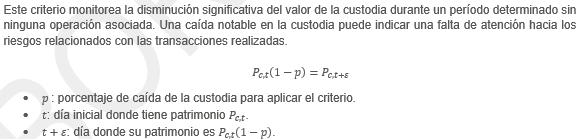

In [74]:
custodia_detalle_test = df_custodia_detalle.copy()
operaciones_consolidado_test = df_operaciones.copy()

# DATE TIME
custodia_detalle_test['fecha_cierre'] = pd.to_datetime(custodia_detalle_test['fecha_cierre'])
operaciones_consolidado_test['FECHA_OPERACION'] = pd.to_datetime(operaciones_consolidado_test['FECHA_OPERACION'])

# CAIDA VALOR
p = 7/100
pat_min = 4_000_000
caida_min = 1_000_000

# AÑO MES
custodia_detalle_test['MES'] = custodia_detalle_test['fecha_cierre'].dt.to_period('M')
operaciones_consolidado_test['MES'] = operaciones_consolidado_test['FECHA_OPERACION'].dt.to_period('M')

# CUSTODIA VALORIZADA DIARIA
suma_valor_diario = custodia_detalle_test.groupby(['IDENTIFICADOR', 'fecha_cierre']).agg(
    VALOR_MERCADO_DIA=('VALOR_MERCADO_CLP', 'sum')
).reset_index()

suma_valor_diario_minimo = suma_valor_diario[suma_valor_diario['VALOR_MERCADO_DIA'] > pat_min]

# OBTENER VALOR INICIO Y FIN DE MES
custodias_inicio_fin_mes = suma_valor_diario_minimo.groupby(['IDENTIFICADOR', suma_valor_diario_minimo['fecha_cierre'].dt.to_period('M')]).agg(
    VALOR_INICIO_MES=('VALOR_MERCADO_DIA', 'first'),
    VALOR_FIN_MES=('VALOR_MERCADO_DIA', 'last'),
    FECHA_INICIO=('fecha_cierre', 'first'),
    FECHA_FIN=('fecha_cierre', 'last')
).reset_index()

# Renombrar la columna de periodo a AÑO_MES para hacer el merge
custodias_inicio_fin_mes.rename(columns={'fecha_cierre': 'MES'}, inplace=True)

# MERGE CON OPERACIONES PARA OBTENER LAS OPERACIONES DENTRO DEL MISMO PERÍODO
custodias_con_operaciones = pd.merge(custodias_inicio_fin_mes, 
                                     operaciones_consolidado_test[['IDENTIFICADOR', 'MES', 'FECHA_OPERACION']],
                                     on=['IDENTIFICADOR', 'MES'], 
                                     how='left')

# CAIDA EN VALOR
custodias_con_operaciones['CAIDA_VALOR'] = (custodias_con_operaciones['VALOR_INICIO_MES'] - custodias_con_operaciones['VALOR_FIN_MES']) 
# FILTRAR CASOS DONDE LA CAÍDA DE VALOR SEA MAYOR O IGUAL AL 20% Y NO HAYA OPERACIONES EN ESE PERÍODO
resultados = custodias_con_operaciones[
    (custodias_con_operaciones['CAIDA_VALOR'] >= custodias_con_operaciones['VALOR_INICIO_MES']*p) &
    (custodias_con_operaciones['FECHA_OPERACION'].isna())
]


df_caida_significativa = resultados[['IDENTIFICADOR', 'VALOR_INICIO_MES', 'VALOR_FIN_MES', 'FECHA_INICIO', 'FECHA_FIN', 'CAIDA_VALOR']]
df_caida_significativa = df_caida_significativa[df_caida_significativa['CAIDA_VALOR'] > caida_min]

In [75]:
df_caida_significativa = pd.merge(df_caida_significativa, df_muestra2[['IDENTIFICADOR', 'NOMBRE_CLIENTE','TIPO_PER','RIESGO']], on='IDENTIFICADOR', how='left').fillna(' ')

In [76]:
df_caida_significativa_color = df_caida_significativa.copy()
############### COLOR ##################
unique_ids = df_caida_significativa_color['IDENTIFICADOR'].unique()
num_ids = len(unique_ids)
colors = matplotlib.cm.get_cmap('tab20', num_ids)
color_map = {id_: f'background-color: {matplotlib.colors.rgb2hex(colors(i))}' for i, id_ in enumerate(unique_ids)}
def auto_color_identificador(val):
    return color_map.get(val, '')
df_caida_significativa_color = (
    df_caida_significativa_color
    .style
    .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])
)

df_caida_significativa_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\1664451877.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('tab20', num_ids)
C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\1664451877.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(auto_color_identificador, subset=['IDENTIFICADOR'])


,IDENTIFICADOR,VALOR_INICIO_MES,VALOR_FIN_MES,FECHA_INICIO,FECHA_FIN,CAIDA_VALOR,NOMBRE_CLIENTE,TIPO_PER,RIESGO
0,17401828-6,69656682,64616572,2024-08-01 00:00:00,2024-08-31 00:00:00,5040110,GONZALO ELIZALDE PEÑA,NATURAL,



# LOGICA  NIVELES DE ALERTA

In [77]:
df_caida_significativa['MES'] = df_caida_significativa['FECHA_INICIO'].dt.to_period('M')
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')
df_monto_inmovilizado['MES'] = df_monto_inmovilizado['FECHA_CIERRE'].dt.to_period('M')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\17293857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')


In [78]:
peso_alertas = {
    2: ['Señal_Primer_Aporte_Grande_Alerta','Señal_Aporte_Diario_Grande', 'df_alerta_FRECUENCIARETIROS', 'df_aporte_mayor_custodia', 'df_alerta_APORTESIMILARES', 'Señal_Aporte_Mensual_Grande'], 
    3: ['df_alerta_FRECUENCIAAPORTES', 'df_caida_significativa', 'df_alerta_RETIROSSIMILARES'],
    5: ['df_alerta_APORTESUPERAUMBRAL', 'df_alerta_OPERACIONSUPERAUMBRAL', 'df_monto_inmovilizado'],
}

alert_map = {
    'df_alerta_APORTESUPERAUMBRAL': (df_alerta_APORTESUPERAUMBRAL, 'APORTE SUPERA UMBRAL'),
    'df_alerta_APORTESIMILARES': (df_alerta_APORTESIMILARES, 'APORTES SIMILARES'),
    'df_aporte_mayor_custodia': (df_aporte_mayor_custodia, 'APORTE MAYOR A CUSTODIA'),

    'Señal_Primer_Aporte_Grande_Alerta': (Señal_Aporte_Diario_Grande, 'PRIMER APORTE ELEVADO'),
    'Señal_Aporte_Diario_Grande': (Señal_Aporte_Diario_Grande, 'APORTES DIARIO ELEVADO'),
    'Señal_Aporte_Mensual_Grande': (Señal_Aporte_Mensual_Grande, 'APORTES MENSUAL ELEVADO'),

    'df_monto_inmovilizado': (df_monto_inmovilizado, 'APORTE INMOVILIZADO'),
    
    'df_alerta_FRECUENCIAAPORTES': (df_alerta_FRECUENCIAAPORTES, 'AUMENTO FRECUENCIA APORTES'),
    'df_alerta_RETIROSSIMILARES': (df_alerta_RETIROSSIMILARES, 'RETIROS SIMILARES'),
    'df_alerta_FRECUENCIARETIROS': (df_alerta_FRECUENCIARETIROS, 'AUMENTO FRECUENCIA RETIROS'),
    
    'df_alerta_OPERACIONSUPERAUMBRAL': (df_alerta_OPERACIONSUPERAUMBRAL, 'OPERACION SUPERA UMBRAL'),
    'df_caida_significativa': (df_caida_significativa, 'CAIDA SIGNIFICATIVA CUSTODIA')
}


results = []
for weight, alerts in peso_alertas.items():
    for alert in alerts:
        if alert in alert_map:
            dataframe, description = alert_map[alert]
            for index, row in dataframe.iterrows():
                results.append({
                    'IDENTIFICADOR': row['IDENTIFICADOR'],
                    'MES': row['MES'],
                    'SCORE': weight,
                    'DATAFRAME': description
                })

In [79]:
df_results = pd.DataFrame(results)
df_results_METODO1 = pd.pivot_table(df_results, values='SCORE', index=['IDENTIFICADOR','DATAFRAME'],columns=['MES'], aggfunc='sum')
df_results_METODO1 = df_results_METODO1.reset_index()
df_results_METODO1 = df_results_METODO1.fillna(0)
df_results_METODO1 = df_results_METODO1.rename_axis(None, axis=1)

In [80]:
######### CREACION MESES ADICIONALES
df_results_METODO2 = df_results_METODO1.copy()

all_months = pd.date_range(start='2022-01', end='2024-11', freq='MS').strftime('%Y-%m').tolist()
df_results_METODO2 = df_results_METODO2.set_index(['IDENTIFICADOR', 'DATAFRAME'])

df_results_METODO2.columns = df_results_METODO2.columns.astype(str)

for month in all_months:
    if month not in df_results_METODO2.columns:
        df_results_METODO2[month] = 0.0

# Volver a organizar las columnas de meses en orden cronológico
months_columns = sorted([col for col in df_results_METODO2.columns if col not in ['IDENTIFICADOR', 'DATAFRAME']])
# Reindexar el DataFrame incluyendo las columnas en orden
df_results_METODO2 = df_results_METODO2.reindex(columns=months_columns)
# Resetear el índice para volver al formato original
df_results_METODO2 = df_results_METODO2.reset_index()

df_results_METODO2.head(5)

,IDENTIFICADOR,DATAFRAME,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
0,10074072-9,APORTES SIMILARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
1,10577379-K,APORTE SUPERA UMBRAL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0
2,11277742-3,APORTE SUPERA UMBRAL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0
3,11833342-K,APORTE MAYOR A CUSTODIA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
4,11862862-4,APORTE MAYOR A CUSTODIA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


In [81]:
df_results = df_results_METODO2.copy()
months = df_results_METODO2.columns[2:]

for index, row in df_results_METODO2.iterrows():
    for i, month in enumerate(months[:-2]):
        if row[month] != 0:
            df_results.at[index, months[i+1]] += row[month]
            df_results.at[index, months[i+2]] += row[month]

In [82]:
df_results_METODO2_sum = df_results.groupby('IDENTIFICADOR').sum().reset_index()
del df_results_METODO2_sum['DATAFRAME']

In [83]:
resultados = []

# Combinar los DataFrames para obtener la información de riesgo de cada cliente
df_combinado = pd.merge(df_results_METODO2_sum, df_muestra2[['IDENTIFICADOR', 'RIESGO','TIPO_PER','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna('')

# NIVELES Y EVALUACIÓN
for index, row in df_combinado.iterrows():
    identificador = row['IDENTIFICADOR']
    riesgo = row['RIESGO']
    
    for mes in df_combinado.columns[1:-1]:  # Evitamos la columna RIESGO en las fechas
        puntaje = row[mes]
        puntaje = pd.to_numeric(puntaje, errors='coerce')
        
        # Flujo diferenciado basado en el riesgo
        if pd.notna(puntaje) and puntaje != 0:
            if riesgo in ['PEP', 'JUDICIAL', 'ALTO']:
                if puntaje >= 5:
                    estado = 'REVISION'
                else:
                    estado = 'MONITOREO' if 1 <= puntaje < 5 else 'HALLAZGO'
            else:
                # Para clientes sin riesgo específico (NaN)
                if 1 <= puntaje <= 4:
                    estado = 'HALLAZGO'
                elif 5 <= puntaje <= 9:
                    estado = 'MONITOREO'
                else:
                    estado = 'REVISION'
            
            resultados.append({
                'IDENTIFICADOR': identificador,
                'MES': mes,
                'PUNTAJE': puntaje,
                'ESTADO': estado,
                'RIESGO': riesgo
            })


df_resultados_estado = pd.DataFrame(resultados)

# Aplicar reglas adicionales para ajustar estados basados en secuencias de "HALLAZGO" o "MONITOREO"
for identificador, group in df_resultados_estado.groupby('IDENTIFICADOR'):
    group = group.reset_index(drop=True)
    
    for i in range(len(group) - 3):  # Aseguramos que haya al menos 4 registros consecutivos
        subset = group.iloc[i:i+4]  # Tomamos 4 filas consecutivas
        
        # Si todos los estados en este grupo son HALLAZGO o MONITOREO y la suma de los puntajes supera 26, cambiar a REVISION
        if subset['ESTADO'].isin(['HALLAZGO', 'MONITOREO']).all() and subset['PUNTAJE'].sum() > 26:
            df_resultados_estado.loc[(df_resultados_estado['IDENTIFICADOR'] == identificador) & 
                                     (df_resultados_estado['MES'] == subset.iloc[3]['MES']), 'ESTADO'] = 'REVISION'


In [84]:
############################### FILTRA REVISION PARA NO REPETIR ALERTA
rows_to_keep = []

# Iterar sobre cada grupo de IDENTIFICADOR
for identificador, group in df_resultados_estado.groupby('IDENTIFICADOR'):
    # Ordenar el grupo por MES
    group = group.sort_values(by='MES')
    # Iterar sobre las filas del grupo
    previous_row = None
    for index, row in group.iterrows():
        if row['ESTADO'] == 'REVISION':
            if previous_row is None or row['PUNTAJE'] != previous_row['PUNTAJE']:
                rows_to_keep.append(row)
            previous_row = row
        if row['ESTADO'] == 'MONITOREO': 
            rows_to_keep.append(row)
        if row['ESTADO'] == 'HALLAZGO': 
            rows_to_keep.append(row)

############################### FILTRA REVISION PARA NO REPETIR ALERTA
filtered_df = pd.DataFrame(rows_to_keep)
filtered_df = filtered_df.reset_index(drop=True)
df_filtered = filtered_df.copy()

In [85]:
df_filtered = pd.merge(df_filtered, df_muestra2[['IDENTIFICADOR','TIPO_PER','NOMBRE_CLIENTE']], on='IDENTIFICADOR', how='left').fillna('')

# ANALISIS ALERTAS GENERADAS

In [86]:
df_rev_mon = df_filtered[(df_filtered['ESTADO'] == 'REVISION') | (df_resultados_estado['ESTADO'] == 'MONITOREO')]
df_filtrado_dof = df_rev_mon.drop_duplicates(subset=['IDENTIFICADOR'], keep='first').reset_index(drop=True)

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\3185496423.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rev_mon = df_filtered[(df_filtered['ESTADO'] == 'REVISION') | (df_resultados_estado['ESTADO'] == 'MONITOREO')]


In [87]:
c1 = df_filtrado_dof['ESTADO'] == 'REVISION'
c2 = df_filtrado_dof['ESTADO'] == 'MONITOREO'
df_analisis = df_filtrado_dof[c1|c2].sort_values(by='MES').reset_index(drop=True)

In [88]:
suma_valor_diario['MES'] = suma_valor_diario['fecha_cierre'].dt.to_period('M')

In [89]:
def obtener_maximos(cliente_id, mes):

    c1p = suma_valor_diario['MES'] == mes
    c2p = suma_valor_diario['IDENTIFICADOR'] == cliente_id
    
    #  (custodia)
    df_custodia = suma_valor_diario[c1p & c2p]
    if not df_custodia.empty:
        max_custodia = df_custodia.loc[df_custodia['VALOR_MERCADO_DIA'].idxmax()]
        valor_max_custodia = max_custodia['VALOR_MERCADO_DIA']
        fecha_max_custodia = max_custodia['fecha_cierre']
    else:
        valor_max_custodia = None
        fecha_max_custodia = None
    
    # (operación diaria)
    c1o = df_filtrado['IDENTIFICADOR'] == cliente_id
    df_operacion = df_filtrado[c1o]
    if not df_operacion.empty:
        max_operacion = df_operacion.loc[df_operacion['total_monto_diario'].idxmax()]
        valor_max_operacion = max_operacion['total_monto_diario']
        fecha_max_operacion = max_operacion['FECHA_OPERACION']
    else:
        valor_max_operacion = None
        fecha_max_operacion = None

    # (aporte diario)
    c1a = df_diario_A['IDENTIFICADOR'] == cliente_id
    df_aporte = df_diario_A[c1a]
    if not df_aporte.empty:
        max_aporte = df_aporte.loc[df_aporte['total_monto_diario'].idxmax()]
        valor_max_aporte = max_aporte['total_monto_diario']
        fecha_max_aporte = max_aporte['FECHA_MOVIMIENTO']
    else:
        valor_max_aporte = None
        fecha_max_aporte = None

    return {
        'max_pat': valor_max_custodia,
        'fecha_pat': fecha_max_custodia,
        'max_op': valor_max_operacion,
        'fecha_op': fecha_max_operacion,
        'max_ap': valor_max_aporte,
        'fecha_ap': fecha_max_aporte
    }

# almacenar los resultados
df_analisis['max_pat'] = None
df_analisis['fecha_pat'] = None
df_analisis['max_op'] = None
df_analisis['fecha_op'] = None
df_analisis['max_ap'] = None
df_analisis['fecha_ap'] = None

# Iterar sobre cada fila en df_analisis
for idx, row in df_analisis.iterrows():
    cliente_id = row['IDENTIFICADOR']
    mes = row['MES']
    
    maximos = obtener_maximos(cliente_id, mes)
    df_analisis.at[idx, 'max_pat'] = maximos['max_pat']
    df_analisis.at[idx, 'fecha_pat'] = maximos['fecha_pat']
    df_analisis.at[idx, 'max_op'] = maximos['max_op']
    df_analisis.at[idx, 'fecha_op'] = maximos['fecha_op']
    df_analisis.at[idx, 'max_ap'] = maximos['max_ap']
    df_analisis.at[idx, 'fecha_ap'] = maximos['fecha_ap']

In [90]:
def crear_columna_envio_dof(df):
    df['Envio DOF'] = df.apply(
        lambda row: (
            
            (row['TIPO_PER'] == 'NATURAL' and 
            ((row['max_pat'] or 0) > 40_000_000 or 
             (row['max_op'] or 0) > 15_000_000 or 
             (row['max_ap'] or 0) > 40_000_000)) or

            (row['TIPO_PER'] == 'NATURAL' and row['RIESGO'] == 'PEP' and
            ((row['max_pat'] or 0) > 25_000_000 or 
             (row['max_op'] or 0) > 8_000_000 or 
             (row['max_ap'] or 0) > 25_000_000)) or

            (row['TIPO_PER'] == 'JURÍDICA' and 
            ((row['max_pat'] or 0) > 200_000_000 or 
             (row['max_op'] or 0) > 100_000_000 or 
             (row['max_ap'] or 0) > 200_000_000))
        ),
        axis=1
    )
    return df

df_analisis = crear_columna_envio_dof(df_analisis)

#### CONTINUACION LÓGICA

In [91]:
### ESTADISTICA ALERTAS
revision = df_filtered[df_filtered['ESTADO'] == 'REVISION'].reset_index(drop=True)
monitoreo = df_filtered[df_filtered['ESTADO'] == 'MONITOREO'].reset_index(drop=True)
hallazgo = df_filtered[df_filtered['ESTADO'] == 'HALLAZGO'].reset_index(drop=True)


print(f"Cantidad de clientes con señales de alerta: {df_filtered['IDENTIFICADOR'].nunique()}  \n" + 
      f"Clientes que se les asigna REVISIÓN: {revision['IDENTIFICADOR'].nunique()}  \n" +
      f"Clientes que se les asigna MONITOREO: {monitoreo['IDENTIFICADOR'].nunique()}  \n" +
      f"Clientes que se les asigna HALLAZGO: {hallazgo['IDENTIFICADOR'].nunique()}  \n" 
     
     )

Cantidad de clientes con señales de alerta: 127  
Clientes que se les asigna REVISIÓN: 28  
Clientes que se les asigna MONITOREO: 48  
Clientes que se les asigna HALLAZGO: 76  



In [92]:
resultado = df_filtered.groupby(['MES', 'ESTADO']).size().reset_index(name='Count')
pivot_table = resultado.pivot_table(index='MES', columns='ESTADO', values='Count', fill_value=0)

In [93]:
df_filtered_color = df_filtered.copy()

def color_estado(val):
    colors = {
        'REVISION': 'color: red',
        'MONITOREO': 'color: orange',
        'HALLAZGO': 'color: green'
    }
    return colors.get(val, '')

df_filtered_color = df_filtered_color.style.format({
    'PUNTAJE': '{:.1f}'
}).applymap(color_estado, subset=['ESTADO'])
#df_filtered_color

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\745892264.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(color_estado, subset=['ESTADO'])


# INTERFAZ SEÑALES DE ALERTA 

In [94]:
df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')
#df_caida_significativa['MES'] = df_caida_significativa['FECHA_INICIO'].dt.to_period('M')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_21232\2547055310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aporte_mayor_custodia['MES'] = df_aporte_mayor_custodia['fecha_cierre'].dt.to_period('M')


In [95]:
# EXTRAER INFO PERSONAL
info_personal_cols = ['NOMBRE_CLIENTE', 'FECHA_NACIMIENTO', 'IDENTIFICADOR', 'COD_PAIS', 'PROFESION', 'EMPLEADOR', 'CARGO']
df_info_personal = df_DATOS_clientes[info_personal_cols].drop_duplicates(subset='IDENTIFICADOR')

# EXTRAER DATOS DE CUENTAS
datos_cuentas_cols = ['IDENTIFICADOR','NUM_CUENTA', 'NOMBRE_ASESOR', 'DSC_CUENTA', 'ESTADO_CUENTA', 'COD_MONEDA', 'FECHA_OPERATIVA']
df_datos_cuentas = df_DATOS_clientes[datos_cuentas_cols]

In [96]:
for e in ['fecha_op','fecha_ap','fecha_pat']:
    df_analisis[e] = pd.to_datetime(df_analisis[e])
    df_analisis[e] = df_analisis[e].dt.strftime('%Y-%m-%d')

In [97]:
pd.options.display.float_format = "{:,.0f}".format

In [98]:
df_analisis['max_pat'] = pd.to_numeric(df_analisis['max_pat'], errors='coerce')

In [99]:
del df_analisis['fecha_pat']

#### Reorder columns for interfaz

In [100]:
display(df_caida_significativa.sample())
display(df_caida_significativa.columns)

,IDENTIFICADOR,VALOR_INICIO_MES,VALOR_FIN_MES,FECHA_INICIO,FECHA_FIN,CAIDA_VALOR,NOMBRE_CLIENTE,TIPO_PER,RIESGO,MES
0,17401828-6,69656682,64616572,2024-08-01,2024-08-31,5040110,GONZALO ELIZALDE PEÑA,NATURAL,,2024-08


Index(['IDENTIFICADOR', 'VALOR_INICIO_MES', 'VALOR_FIN_MES', 'FECHA_INICIO',
       'FECHA_FIN', 'CAIDA_VALOR', 'NOMBRE_CLIENTE', 'TIPO_PER', 'RIESGO',
       'MES'],
      dtype='object')

In [101]:
df_alerta_APORTESUPERAUMBRAL = df_alerta_APORTESUPERAUMBRAL[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'fecha_aporte', 'aporte_actual', 'promedio_aportes', 'std_aportes', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_APORTESIMILARES = df_alerta_APORTESIMILARES[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'promedio_aportes', 'std_aportes','count_aportes', 'coef_var', 'alerta',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_FRECUENCIAAPORTES = df_alerta_FRECUENCIAAPORTES[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'aportes_actual', 'promedio_aportes','std_aportes', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

Señal_Primer_Aporte_Grande_Alerta = Señal_Primer_Aporte_Grande_Alerta[['MES', 'IDENTIFICADOR', 'NOMBRE_CLI',
                                                             'FECHA_MOVIMIENTO', 'MONTO_CLP',
                                                             'TIPO_PER', 'RIESGO']]

Señal_Aporte_Diario_Grande = Señal_Aporte_Diario_Grande[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'FECHA_MOVIMIENTO', 'total_monto_diario','M_diario', 'primer_dia',
                                                             'TIPO_PER', 'RIESGO']]

Señal_Aporte_Mensual_Grande = Señal_Aporte_Mensual_Grande[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'total_monto_mensual', 'dias_aportes','M_mensual',
                                                             'TIPO_PER', 'RIESGO']]

df_monto_inmovilizado = df_monto_inmovilizado[['MES', 'IDENTIFICADOR', 'NOMBRE_CLI',
                                                             'NOMBRE_ASESOR', 'NUM_CUENTA','FECHA_CIERRE','TIPO_CAJA','MONTO_MON_CAJA','MONTO_EN_PESOS','TRANSITO','is_empty',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_RETIROSSIMILARES = df_alerta_RETIROSSIMILARES[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'promedio_rescates', 'std_rescates','count_rescates', 'coef_var', 'alerta',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_FRECUENCIARETIROS = df_alerta_FRECUENCIARETIROS[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'rescates_actual', 'promedio_rescate','std_rescate', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

df_caida_significativa = df_caida_significativa[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'FECHA_INICIO','VALOR_INICIO_MES', 'FECHA_FIN','VALOR_FIN_MES', 'CAIDA_VALOR',
                                                             'TIPO_PER', 'RIESGO']]

df_alerta_OPERACIONSUPERAUMBRAL = df_alerta_OPERACIONSUPERAUMBRAL[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'FECHA_OPERACION', 'producto','operacion_actual', 'promedio_operacion', 'std_operacion', 'umbral',
                                                             'TIPO_PER', 'RIESGO']]

df_aporte_mayor_custodia = df_aporte_mayor_custodia[['MES', 'IDENTIFICADOR', 'NOMBRE_CLIENTE',
                                                             'fecha_cierre', 'VALOR_MERCADO_CLP', 'MONTO_CLP',
                                                             'TIPO_PER', 'RIESGO']]

#### Rename columns for interfaz

In [102]:
## APORTE SUPERA UMBRAL
df_alerta_APORTESUPERAUMBRAL = df_alerta_APORTESUPERAUMBRAL.rename(columns={"aporte_actual": "Aporte", 
                                             "promedio_aportes": "Promedio",
                                             "std_aportes": "Desviación_STD",
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "Mes"
                                            }, 
                                    errors="raise")

## APORTESIMILARES
df_alerta_APORTESIMILARES = df_alerta_APORTESIMILARES.rename(columns={"MES": "Mes", 
                                             "promedio_aportes": "Cantidad_Promedio",
                                             "std_aportes": "Cantidad_STD",
                                             "count_aportes": "Cantidad_Aportes",
                                             "coef_var": "Coef_Variacion",
                                             "alerta": "Alerta",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                            }, 
                                    errors="raise")

## df_alerta_FRECUENCIAAPORTES
df_alerta_FRECUENCIAAPORTES = df_alerta_FRECUENCIAAPORTES.rename(columns={"MES": "Mes", 
                                             "aportes_actual": "Cantidad_Aportes",                              
                                             "promedio_aportes": "Promedio_Cantidad",
                                             "std_aportes": "Cantidad_STD",
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                            }, 
                                    errors="raise")

In [103]:
## PRIMER APORTE DIARIO ELEVADO
Señal_Primer_Aporte_Grande_Alerta = Señal_Primer_Aporte_Grande_Alerta.rename(columns={
                                             "NOMBRE_CLI": "Nombre_Cliente",
                                             "MONTO_CLP": "Monto_CLP",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "Mes"                                 
                                            }, 
                                    errors="raise")


## APORTES DIARIO ELEVADO
del Señal_Aporte_Diario_Grande['M_diario']
del Señal_Aporte_Diario_Grande['primer_dia']
Señal_Aporte_Diario_Grande = Señal_Aporte_Diario_Grande.rename(columns={
                                             "total_monto_diario": "Total_Aporte_Diario",
                                             "MES": "Mes",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente"
                                            }, 
                                    errors="raise")

## APORTES MENSUAL ELEVADO
del Señal_Aporte_Mensual_Grande['M_mensual']
Señal_Aporte_Mensual_Grande = Señal_Aporte_Mensual_Grande.rename(columns={
                                             "MES": "Mes",
                                             "total_monto_mensual": "Total_Aporte_Mensual",
                                             "dias_aportes": "Dias_Aportes",                          
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente"
                                            }, 
                                    errors="raise")

In [104]:
## MONTO INMOVILIZADO
del df_monto_inmovilizado['NOMBRE_ASESOR']
df_monto_inmovilizado = df_monto_inmovilizado.rename(columns={
                                             "NUM_CUENTA": "Cuenta",
                                             "NOMBRE_CLI": "Nombre_Cliente",
                                             "TIPO_CAJA": "Tipo_Caja",
                                             "MONTO_MON_CAJA": "Monto_Mon_Caja",
                                             "MONTO_EN_PESOS": "Monto_Pesos",                                 
                                             "TRANSITO": "Transito",   
                                             "MES": "Mes",                                 
                                             "is_empty": "Sin_Operaciones",                                     
                                            }, 
                                    errors="raise")

## RETIROS SIMILARES
df_alerta_RETIROSSIMILARES = df_alerta_RETIROSSIMILARES.rename(columns={"MES": "Mes", 
                                             "promedio_rescates": "Promedio",
                                             "std_rescates": "Desviación_STD",
                                             "count_rescates": "Cantidad_Rescates",
                                             "coef_var": "Coef_Variacion",
                                             "alerta": "Alerta",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo"                        
                                            }, 
                                    errors="raise")


## FRECUENCIA RETIROS
df_alerta_FRECUENCIARETIROS = df_alerta_FRECUENCIARETIROS.rename(columns={"MES": "Mes", 
                                             "rescates_actual": "Cantidad_Rescate",                              
                                             "promedio_rescate": "Cantidad_Promedio",
                                             "std_rescate": "Cantidad_DSTD",
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo"
                                            }, 
                                    errors="raise")

## CAIDA SIGNIFICATIVA CUSTODIA
df_caida_significativa = df_caida_significativa.rename(columns={ 
                                             "VALOR_INICIO_MES": "Valorizado_Inicio",                              
                                             "VALOR_FIN_MES": "Valorizado_Final",
                                             "FECHA_INICIO": "Fecha_Inicio",
                                             "FECHA_FIN": "Fecha_Fin",
                                             "CAIDA_VALOR": "Caida_Valor",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",           
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "Mes"       
                                            }, 
                                    errors="raise")


## OPERACION SUPERA UMBRAL
df_alerta_OPERACIONSUPERAUMBRAL = df_alerta_OPERACIONSUPERAUMBRAL.rename(columns={"operacion_actual": "Monto_operado_dia",  
                                             "promedio_operacion": "Promedio_Operacion",
                                             "std_operacion": "Desviación_STD",                          
                                             "umbral": "Umbral",
                                             "NOMBRE_CLIENTE": "Nombre_Cliente",
                                             "TIPO_PER": "Persona",
                                             "RIESGO": "Riesgo",
                                             "MES": "Mes"
                                            }, 
                                    errors="raise")


In [105]:
## APORTE MAYOR A LA CUSTODIA
df_aporte_mayor_custodia = df_aporte_mayor_custodia.rename(columns={
                                             "VALOR_MERCADO_CLP": "Custodia", 
                                             "MONTO_CLP": "Aporte",                          
                                             "MES": "Mes"
                                            }, 
                                   errors="raise")

In [106]:
df_monto_inmovilizado['Monto_Mon_Caja'] = df_monto_inmovilizado['Monto_Mon_Caja'].astype(float)
df_monto_inmovilizado['Monto_Pesos'] = df_monto_inmovilizado['Monto_Pesos'].astype(float)
df_caida_significativa['Valorizado_Inicio'] = df_caida_significativa['Valorizado_Inicio'].astype(float)
df_caida_significativa['Valorizado_Final'] = df_caida_significativa['Valorizado_Final'].astype(float)
df_caida_significativa['Caida_Valor'] = df_caida_significativa['Caida_Valor'].astype(float)
df_aporte_mayor_custodia['Custodia'] = df_aporte_mayor_custodia['Custodia'].astype(float)
df_operaciones['Mes'] = df_operaciones['FECHA_OPERACION'].dt.to_period('M') 

pd.options.display.float_format = "{:,.0f}".format

## INTERFAZ

In [107]:
class AlertaBase:
    def __init__(self, df_alerta, df_combinado, file_suffix):
        self.df_alerta = df_alerta
        self.df_combinado = df_combinado
        self.file_suffix = file_suffix

    def buscar_identificador(self, identificador):
        """Busca en el DataFrame de alerta por identificador."""
        return self.df_alerta[self.df_alerta['IDENTIFICADOR'] == identificador]

    def ver_operaciones(self, identificador, mes_alerta):
        """Obtiene las operaciones relacionadas con el identificador y el mes de alerta."""
        return self.df_combinado[(self.df_combinado['IDENTIFICADOR'] == identificador) & (self.df_combinado['Mes'].isin(mes_alerta))]

In [108]:
df_filtered.sample()

,IDENTIFICADOR,MES,PUNTAJE,ESTADO,RIESGO,TIPO_PER,NOMBRE_CLIENTE
376,7888425-8,2024-03,2,HALLAZGO,,NATURAL,OLGA VILDOSOLA VILDOSOLA


In [109]:
df_analisis.sample()

,IDENTIFICADOR,MES,PUNTAJE,ESTADO,RIESGO,TIPO_PER,NOMBRE_CLIENTE,max_pat,max_op,fecha_op,max_ap,fecha_ap,Envio DOF
37,15641707-6,2024-09,15,REVISION,,NATURAL,MATIAS EDUARDO GOLDSMITH DUENAS,"306,942,588","94,842,977",2024-09-23,"34,370,027",2023-10-04,True


##### Interfaz test 2

In [110]:
class App(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("SEÑALES DE ALERTA MONITOREO TRANSACCIONAL")
        self.geometry("1500x700")

        self.configure(bg="#E8ECEF")  # Color azul claro como fondo
        
        # INICIALIZAR ALERTAS
        self.alertas = {
            'APORTE SUPERA UMBRAL':AlertaBase(df_alerta_APORTESUPERAUMBRAL, df_combinado_A, 'APORTE SUPERA UMBRAL'),
            'APORTES SIMILARES': AlertaBase(df_alerta_APORTESIMILARES, df_combinado_A, 'APORTES SIMILARES'),
            'AUMENTO FRECUENCIA DE APORTES': AlertaBase(df_alerta_FRECUENCIAAPORTES, df_combinado_A, 'AUMENTO FRECUENCIA DE APORTES'),

            'PRIMER APORTE DIARIO ELEVADO': AlertaBase(Señal_Primer_Aporte_Grande_Alerta, df_combinado_A, 'PRIMER APORTE DIARIO ELEVADO'),
            'APORTES DIARIO ELEVADO': AlertaBase(Señal_Aporte_Diario_Grande, df_combinado_A, 'APORTES DIARIO ELEVADO'),
            'APORTES MENSUAL ELEVADO': AlertaBase(Señal_Aporte_Mensual_Grande, df_combinado_A, 'APORTES MENSUAL ELEVADO'),
            'APORTE INMOVILIZADO': AlertaBase(df_monto_inmovilizado, df_saldo_caja, 'APORTE INMOVILIZADO'),
            
            'ALERTA RETIROS SIMILARES': AlertaBase(df_alerta_RETIROSSIMILARES, df_combinado_R, 'ALERTA RETIROS_SIMILARES'),
            'AUMENTO FRECUENCIA DE RETIROS': AlertaBase(df_alerta_FRECUENCIARETIROS, df_combinado_R, 'SEÑAL AUMENTO FRECUENCIA DE RETIROS'),
            'CAIDA PATRIMONIO': AlertaBase(df_caida_significativa, df_custodia_detalle, 'CAIDA PATRIMONIO'),
            'UMBRAL OPERACIONES': AlertaBase(df_alerta_OPERACIONSUPERAUMBRAL, df_operaciones, 'UMBRAL OPERACIONES'),
            'APORTE MAYOR CUSTODIA': AlertaBase(df_aporte_mayor_custodia, df_combinado_A, 'APORTE MAYOR CUSTODIA'),       
        }

        self.logo_gpi = tk.PhotoImage(file="Logo_gpi.png")
        self.create_widgets()

    def create_widgets(self):
        """Crea y ubica todos los widgets de la interfaz gráfica."""
        # Imágenes
        self.logo_gpi_label = tk.Label(self, image=self.logo_gpi)
        self.logo_gpi_label.place(x=240, y=25)

        # Campo de entrada para el RUT del cliente
        self.input_field = ttk.Entry(self)
        self.input_field.insert(0, "  Ingresa RUT cliente")
        self.input_field.place(x=30, y=240, width=120, height=30)

        # Botón para buscar identificador
        self.search_button = ttk.Button(self, text="VER", command=self.buscar_identificador)
        self.search_button.place(x=170, y=240, width=40, height=30)

        # Botón para ver todas las alertas
        self.ver_todas_alertas_button = ttk.Button(self, text="Ver todas las señales de alerta", command=self.ver_todas_alertas)
        self.ver_todas_alertas_button.place(x=30, y=200, width=200, height=30)

        # Botón adicional para mostrar df_filtered
        self.ver_df_filtered_button = ttk.Button(self, text="Ver todas las alertas filtradas", command=self.mostrar_df_filtered)
        self.ver_df_filtered_button.place(x=30, y=320, width=200, height=30)

        # ** Botón para mostrar df_analisis **
        self.ver_df_analisis_button = ttk.Button(self, text="Ver análisis", command=self.mostrar_df_analisis)
        self.ver_df_analisis_button.place(x=30, y=360, width=200, height=30)

        # Campo de texto para mostrar resultados
        self.result_field = tk.Text(self, height=62, width=170, state='disabled')
        self.result_field.place(x=230, y=50)

        # Botón para descargar operaciones
        self.ver_operaciones_button = ttk.Button(self, text="Descargar Operaciones", command=self.ver_operaciones, state='disabled')
        self.ver_operaciones_button.place(x=30, y=280, width=180, height=30)

        # Campo de entrada para el MES
        self.mes_input = ttk.Entry(self)
        self.mes_input.insert(0, "  Ingresa MES: YYYY-MM")
        self.mes_input.place(x=30, y=400, width=160, height=30)

        # Botones para filtrar por ESTADO y MES
        self.hallazgo_button = ttk.Button(self, text="Hallazgo", command=self.mostrar_hallazgo_por_mes)
        self.hallazgo_button.place(x=30, y=440, width=100, height=30)

        self.monitoreo_button = ttk.Button(self, text="Monitoreo", command=self.mostrar_monitoreo_por_mes)
        self.monitoreo_button.place(x=30, y=480, width=100, height=30)

        self.revision_button = ttk.Button(self, text="Revision", command=self.mostrar_revision_por_mes)
        self.revision_button.place(x=30, y=520, width=100, height=30)

        ### ADICIONAL
        # KYC
        self.additional_input = tk.Text(self, height=20, width=30, state='normal')
        self.additional_input.insert('1.0', " Estado KYC: ")
        self.additional_input.place(x=1610, y=250, width=150, height=50)
        self.additional_input.config(state='disabled')  # Disable the widget after inserting the text
        
        # TEXTO
        self.additional_input = tk.Text(self, height=20, width=30, state='normal')
        self.additional_input.insert('1.0', " Comentarios: ")
        self.additional_input.place(x=1610, y=320, width=250, height=150)
        self.additional_input.config(state='disabled')  # Disable the widget after inserting the text

        # FECHA REVISION
        self.additional_input = tk.Text(self, height=20, width=30, state='normal')
        self.additional_input.insert('1.0', " Fecha revisión: ")
        self.additional_input.place(x=1610, y=490, width=200, height=30)
        self.additional_input.config(state='disabled')  # Disable the widget after inserting the text

    def mostrar_df_analisis(self):
        """Muestra el DataFrame df_analisis en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        if not df_analisis.empty:
            self.result_field.insert(tk.END, f"Análisis:\n{df_analisis.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, "No hay datos en df_analisis para mostrar.")

        self.result_field.config(state='disabled')

    def buscar_identificador(self):
        """Busca el identificador y muestra las alertas relacionadas."""
        identificador = self.input_field.get().strip()
        if not identificador:
            self.result_field.config(state='normal')
            self.result_field.delete(1.0, tk.END)
            self.result_field.insert(tk.END, "Por favor, ingresa un identificador válido.")
            self.result_field.config(state='disabled')
            return

        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        alerta_activa = False
        self.alertas_resultados = {}
        for nombre_alerta, alerta in self.alertas.items():
            resultado = alerta.buscar_identificador(identificador)
            if not resultado.empty:
                self.result_field.insert(tk.END, f"{nombre_alerta}:\n{resultado.to_string(index=False)}\n\n")
                alerta_activa = True
                self.alertas_resultados[nombre_alerta] = alerta

        if alerta_activa:
            self.result_field.insert(tk.END, "SEÑALES DE ALERTA")
            self.ver_operaciones_button.config(state='normal')
            self.identificador_actual = identificador
        else:
            self.result_field.insert(tk.END, "No se encontró alerta para este identificador.")
            self.ver_operaciones_button.config(state='disabled')

        self.result_field.config(state='disabled')

    def ver_todas_alertas(self):
        """Muestra todas las alertas en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        for nombre_alerta, alerta in self.alertas.items():
            if not alerta.df_alerta.empty:
                self.result_field.insert(tk.END, f"{nombre_alerta}:\n{alerta.df_alerta.to_string(index=False)}\n\n")

        self.result_field.config(state='disabled')

    def mostrar_df_filtered(self):
        """Muestra el DataFrame df_filtered en el campo de texto."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        if not df_filtered.empty:
            self.result_field.insert(tk.END, f"df_filtered:\n{df_filtered.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, "No hay datos en df_filtered para mostrar.")

        self.result_field.config(state='disabled')

    def obtener_df_filtrado_por_mes(self):
        """Filtra df_filtered según el mes especificado."""
        mes = self.mes_input.get().strip()
        if not mes:
            return pd.DataFrame()  # Retorna un DataFrame vacío si no hay mes

        df_filtrado_por_mes = df_filtered[df_filtered['MES'] == mes]
        return df_filtrado_por_mes

    def mostrar_hallazgo_por_mes(self):
        """Filtra y muestra las filas donde ESTADO es 'HALLAZGO' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_hallazgo = df_mes[df_mes['ESTADO'] == 'HALLAZGO']
        
        if not df_hallazgo.empty:
            self.result_field.insert(tk.END, f"HALLAZGO ({self.mes_input.get()}):\n{df_hallazgo.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'HALLAZGO' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def mostrar_monitoreo_por_mes(self):
        """Filtra y muestra las filas donde ESTADO es 'MONITOREO' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_monitoreo = df_mes[df_mes['ESTADO'] == 'MONITOREO']
        
        if not df_monitoreo.empty:
            self.result_field.insert(tk.END, f"MONITOREO ({self.mes_input.get()}):\n{df_monitoreo.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'MONITOREO' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def mostrar_revision_por_mes(self):
        """Filtra y muestra las filas donde ESTADO es 'REVISION' y coincide con el MES."""
        self.result_field.config(state='normal')
        self.result_field.delete(1.0, tk.END)

        df_mes = self.obtener_df_filtrado_por_mes()
        df_revision = df_mes[df_mes['ESTADO'] == 'REVISION']
        
        if not df_revision.empty:
            self.result_field.insert(tk.END, f"REVISION ({self.mes_input.get()}):\n{df_revision.to_string(index=False)}\n\n")
        else:
            self.result_field.insert(tk.END, f"No se encontraron registros con ESTADO 'REVISION' para el mes {self.mes_input.get()}.")

        self.result_field.config(state='disabled')

    def ver_operaciones(self):
            """Genera un archivo Excel con las operaciones y alertas para el identificador actual."""
            identificador = self.identificador_actual
            with pd.ExcelWriter(f'Operaciones_{identificador}.xlsx', engine='xlsxwriter') as writer:
        
                # Filtra la información del cliente
                df_info_personal_cliente = df_info_personal[df_info_personal['IDENTIFICADOR'] == identificador]
                df_datos_cuenta_cliente = df_datos_cuentas[df_datos_cuentas['IDENTIFICADOR'] == identificador]
                
                # Escribe df_info_personal_cliente en la primera hoja
                df_info_personal_cliente.to_excel(writer, sheet_name='Cliente_Info', index=False, startrow=0)
                
                # Agrega dos filas en blanco antes de escribir df_datos_cuenta_cliente
                startrow = len(df_info_personal_cliente) + 2
                df_datos_cuenta_cliente.to_excel(writer, sheet_name='Cliente_Info', index=False, startrow=startrow)
        
                workbook = writer.book
                cliente_worksheet = writer.sheets['Cliente_Info']
                
                # Formateo de la hoja de cliente
                header_format = workbook.add_format({
                    'bold': True,
                    'text_wrap': True,
                    'valign': 'top',
                    'fg_color': '#022596',
                    'font_color': 'white',
                    'border': 1
                })
                
                # Escribe los encabezados para df_info_personal_cliente
                for col_num, value in enumerate(df_info_personal_cliente.columns.values):
                    cliente_worksheet.write(0, col_num, value, header_format)
                cliente_worksheet.set_default_row(20)
                cliente_worksheet.set_column(0, len(df_info_personal_cliente.columns) - 1, 20)
                
                # Escribe los encabezados para df_datos_cuenta_cliente
                for col_num, value in enumerate(df_datos_cuenta_cliente.columns.values):
                    cliente_worksheet.write(startrow, col_num, value, header_format)
                cliente_worksheet.set_column(0, len(df_datos_cuenta_cliente.columns) - 1, 20)
        
                # Operaciones específicas por tipo de alerta
                for nombre_alerta, alerta in self.alertas_resultados.items():
                    mes_alerta = alerta.df_alerta.loc[alerta.df_alerta['IDENTIFICADOR'] == identificador, 'Mes'].values
                    df_operaciones = alerta.ver_operaciones(identificador, mes_alerta)
                    if not df_operaciones.empty:
                        df_operaciones = df_operaciones.sort_values(by='FECHA_OPERACION')
                        sheet_name = f'{nombre_alerta}_{identificador}'[:31]  # Limitar nombre de la hoja a 31 caracteres
                        df_operaciones.to_excel(writer, sheet_name=sheet_name, index=False)
                        
                        worksheet = writer.sheets[sheet_name]
                        for col_num, value in enumerate(df_operaciones.columns.values):
                            worksheet.write(0, col_num, value, header_format)
                        worksheet.set_default_row(20)
                        worksheet.set_column(0, len(df_operaciones.columns) - 1, 20)
            
            # Actualiza el campo de texto con el mensaje de confirmación
            self.result_field.config(state='normal')
            self.result_field.insert(tk.END, f"\n\nLas operaciones y alertas han sido guardadas en: Operaciones_{identificador}.xlsx")
            self.result_field.config(state='disabled')

if __name__ == "__main__":
    app = App()
    app.mainloop()